In [2]:
%cd /content
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
#udemy_folder = "/content/drive/MyDrive/0_MAESTRIA/1_TEXT/TM_udemy_reviews"
#!cp {udemy_folder}/udemy_reviews.zip udemy_reviews.zip
%cd /content/drive/MyDrive/0_MAESTRIA/1_TEXT/TM_udemy_reviews
!ls
udemy_folder = "."


/content
Mounted at /content/drive
/content/drive/MyDrive/0_MAESTRIA/1_TEXT/TM_udemy_reviews
'!anac.bat'
 dictionary.dict
 heatmap.png
'!jupy.bat'
 LICENSE
 model
 model.zip
 Palabras_destacadas_log_odds_ratio.ipynb
 README.md
 TP4_1_topic_group.ipynb
 TP4_2_topic_group.ipynb
 TP4_topic_group_pos_neg_analisis.ipynb
 udemy_reviews_aggregated.csv.zip
 udemy_reviews_dominant.csv.zip
 udemy_reviews_with_topics.csv.zip
 udemy_reviews.zip


#### Load the libraries

In [3]:
!pip3 install -q -U spacy
!python3 -m spacy download es_core_news_md

     |████████████████████████████████| 43.4 MB 1.2 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_md')


In [4]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)
pd.options.display.float_format = "{:,.2f}".format

### Connect to drive to get the data

In [5]:
df_udemy = pd.read_csv(f'udemy_reviews.zip', compression='zip', header=0, sep=',', quotechar='"')
df_udemy.head()

,id,course,rating,comment,user
0,73015398,1640654,2.50,como introducción esta bien pero deberían de hacerlo mas dirigido a RPA con fotos de RPAS,Jorge Alejandro Castillo
1,50586814,1640654,4.50,Los conocimientos son claros y concisos para lo requerido,Jaime Medina
2,49880684,1640654,5.00,hermoso,Adrián Antonio Herrera Castro
3,47366486,1640654,5.00,Excelente !!!,Márcio Maurício Soares do Nascimento
4,79933910,88380,5.00,Excelente todo!,Emilio Monarrez Hernandez


In [6]:
df_news = df_udemy

In [7]:
# Aplica pos/neg
df_news['tag']=df_news['rating'].apply(lambda x: 'pos' if x >= 4 else 'neg')
# Filtra los que solamente dicen una palabra (ej. "Excelente!")
#df_news = df_news[df_news['comment'].str.contains("\s")]
# Filtra los que tienen menos de 5 palabras
df_news = df_news[df_news['comment'].str.split().str.len().gt(4)]
# Filtra los que dicen menos de 12 letras (ej. "Excelente!")
df_news = df_news[df_news['comment'].str.len() >= 12]
df_news = df_news[df_news['tag']=='neg']#.sample(2000)

df_news.reset_index(inplace=True)
display(df_news.sample(10))

# Recomendación:
# usar los comentarios con >=5 palabras


,index,id,course,rating,comment,user,tag
13255,122565,50474008,2579252,2.50,todo muy bien hasta que llego el momento donde sentí que estaba con un vendedor de herb@life,Raziel Rodriguez Zagal,neg
4751,42884,66034552,1346592,3.00,"se me hace que las clases son muy monotonas , lo cual aburre bastante",Alejandro Carvajal Figueroa,neg
13230,122470,58949616,2579252,1.00,Venta de curso en una plataforma de estudio.. :/ XD,Wilder Noriega,neg
9670,87068,25882300,130480,2.00,Explicaciones carentes de ritmo\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nExplicación carente de ritmo,Sonia Martin Hernandez,neg
7990,72541,80756194,2516170,2.50,"este curso es excelente, muy informativo e interactivo, el profesor no hace las clases pesadas y de vez en cuando hace un par de bromas que hace que el curso se lleve de una manera muy ligera y entretenida.\n\nal principio ya que en la parte de NodeJS, montando nuestra propia API rest serverless con express JS cuando hay algun error (y es muy comun que los haya) el maestro te dejara completamente solo porque: usa mac (y si eres de windows puedes llegar a tener algun problema con descargar recursos de vercel), no usa el mismo edetor de texto (lo cual puede resultar en comandos distintos que puede que te confundan) y lo mas importante es que EL MAESTRO NO RESPONDE PREGUNTAS al menos hasta la fecha hay preguntas de hace meses que los mismos alumnos intentan resolver pero si no pueden esa persona no tiene ningun apoyo ya que las preguntas pueden llegar a ser un tanto especificas para buscar en internet",Alejandro Muñoz,neg
11639,104396,8776562,281508,3.50,El dialogo esta un poco aburrido,Willy Paniagua Carrillo,neg
13505,124041,73778918,935680,2.50,"Para un principiante, que no conoce Tableau no es tan bueno",Javier Vilches,neg
13660,125100,58343655,357322,1.00,no dijo como recibir los pagos,Erik Rene Soltero Salcido,neg
17467,161981,69838976,480548,3.00,"Sirve para introducirte al HTML, a mi modo de ver la parte de CSS esta muy mal explicada y creo que si mezclas las dos cosas los ejemplos para explicar la teoría del HTML y posteriormente el CSS hubiera estado mejor que fuera con un ejemplo real para ir dándole forma.",David Díaz Zamarreño,neg
15914,148310,43625752,1288270,2.50,"no es tan entretenida la charla, se escucha mucho ruido del microfono, como que no esta bien preparada la clase",Erick Fernando Lopez Moreno,neg


In [8]:
!pip install -q --upgrade gensim
import gensim
gensim.__version__

'4.1.2'

In [9]:
import numpy as np
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords
import string
import matplotlib.pyplot as plt
import gensim
import numpy as np
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim.corpora import Dictionary
# from gensim.models.wrappers import LdaMallet


In [10]:
df_news['tag'].value_counts()

neg    18883
Name: tag, dtype: int64

In [11]:
df_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18883 entries, 0 to 18882
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   index    18883 non-null  int64  
 1   id       18883 non-null  int64  
 2   course   18883 non-null  int64  
 3   rating   18883 non-null  float64
 4   comment  18883 non-null  object 
 5   user     18882 non-null  object 
 6   tag      18883 non-null  object 
dtypes: float64(1), int64(3), object(3)
memory usage: 1.0+ MB


#Data Preprocessing

We defined a list of custom words to be exclude from our dataset

Create the cleaner function to clean the spanish text, remove non alpha numeric characters, remove duplicate, remove spanish accutes, remove digits

In [12]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

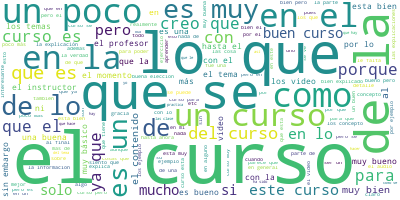

In [13]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(df_news['comment'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()


In [14]:
from nltk import word_tokenize
from nltk.corpus import stopwords
stop = set(stopwords.words('spanish'))

black_list = ['excelente', 'buen','bien','aunque',
              'muchas', 'gracias', 'curso','course','good'
              ]

additional_stopwords=set(black_list)

stopwords_sp = stop.union(additional_stopwords)

from nltk.stem import SnowballStemmer
spanish_stemmer = SnowballStemmer('spanish')
def stemmization(texts):
    texts = re.sub(r"""
                   [,.;@#?!&$]+  # Accept one or more copies of punctuation
                   \ *           # plus zero or more copies of a space,
                   """,
                   " ",          # and replace it with a single space
                   texts, flags=re.VERBOSE)
    return spanish_stemmer.stem(texts).split()


import spacy
nlp = spacy.load('es_core_news_md')
def lemmatization(texts, allowed_postags=['NOUN']):
    #x = nlp(texts)
    #print([(xx.text,xx.pos_) for xx in x])
    texts_out = [ token.text for token in nlp(texts) if token.pos_ in 
                 allowed_postags and token.text not in black_list and len(token.text)>2]
    return texts_out

In [15]:
%%time
bigram = gensim.models.Phrases(df_news['comment'].to_list()) 

CPU times: user 3.1 s, sys: 12.1 ms, total: 3.12 s
Wall time: 3.11 s


In [16]:
def cleaner(word):
    word = re.sub(r'((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*', '', word, flags=re.MULTILINE)
    word = re.sub(r'(?::|;|=)(?:-)?(?:\)|\(|D|P)', "", word)
    word = re.sub(r'ee.uu', 'eeuu', word)
    word = re.sub(r'\#\.', '', word)
    word = re.sub(r'\n', '', word)
    word = re.sub(r',', ' ', word)
    word = re.sub(r'\-', ' ', word)
    word = re.sub(r'\.{3}', ' ', word)
    word = re.sub(r'a{2,}', 'a', word)
    word = re.sub(r'é{2,}', 'é', word)
    word = re.sub(r'i{2,}', 'i', word)
    word = re.sub(r'ja{2,}', 'ja', word) 
    word = re.sub(r'á', 'a', word)
    word = re.sub(r'é', 'e', word)
    word = re.sub(r'í', 'i', word)
    word = re.sub(r'ó', 'o', word)
    word = re.sub(r'ú', 'u', word)  
    word = re.sub('[^a-zA-Z]', ' ', word)
    wordlist = [ token for token in nltk.word_tokenize(word) if token.lower() not in stopwords_sp and len(token)>3 ]
    wordlist = [x for x in wordlist if not any(string for string in black_list if string in x)]
    word = " ".join(wordlist)
    list_word_clean = []
    for w1 in word.split(r"\s"):
        if  w1.lower() not in stopwords_sp:
            list_word_clean.append(w1.lower())

    bigram_list = bigram[list_word_clean]
    out_text = stemmization(" ".join(bigram_list))
    return out_text

In [17]:
cleaner('Curso. Gracias amigo me adentraste e informaste como publicar mejor en Facebook Ads , recomendación mejora tu dicción	')

['amigo',
 'adentraste',
 'informaste',
 'publicar',
 'mejor',
 'facebook',
 'recomendacion',
 'mejora',
 'diccion']

Create the function for select **only nouns** for our data, this way we are removing adverb, adjetives, verbs, etc. This is doing with spacy

For gensim we need a list of text, so we need do convert the dataframe to list

In [18]:
stemmization('Curso. Gracias amigo me adentraste e informaste como publicar mejor en Facebook Ads , recomendación mejora tu dicción')

['curso',
 'gracias',
 'amigo',
 'me',
 'adentraste',
 'e',
 'informaste',
 'como',
 'publicar',
 'mejor',
 'en',
 'facebook',
 'ads',
 'recomendacion',
 'mejora',
 'tu',
 'diccion']

In [19]:
lemmatization('Curso. Gracias amigo me adentraste e informaste como publicar mejor en Facebook Ads , recomendación mejora tu dicción	')

['amigo', 'recomendación', 'dicción']

In [20]:
# import pandas as pd 
# train=pd.DataFrame({'text':['Curso. Gracias amigo me',
#                         'adentraste e informaste como publicar',
#                         'publicar mejor en Facebook Ads',
#                         'recomendación mejora tu dicción']})
# text=pd.DataFrame({'text':['Curso. Gracias amigo me adentraste e informaste como publicar mejor en Facebook Ads , recomendación mejora tu dicción']})


# def sent_to_words(sentences):
#   for sentence in sentences:
#       yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

# #using your train data to train the model with 4 topics

# data_words = list(sent_to_words(train['text']))
# id2word = Dictionary(data_words)
# corpus = [id2word.doc2bow(text) for text in data_words]

# lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
#                                         id2word=id2word,
#                                         num_topics=4)

# #  predicting new text which is in text dataframe  
# new_text_corpus =  id2word.doc2bow(text['text'][0].split())
# lda_model[new_text_corpus]


In [21]:
len(df_news)

18883

In [22]:
# !python -m spacy download es_core_news_md

In [23]:
df_news['comment'].sample(3)

13351                                                                                                                                                                                   va muy rapido pero esta muy chevere
14170                                                                                              En general se ve la complementación básica del acelerometro, pero debe tener un guion para no divagar en la explicación.
10529    Excelente curso, aunque hay contenido un tanto viejito (2016) pero se nota el interés del autor por mejorarlo en los puntos clave. Muy buen manejo de idioma, agradable y profesional. Lo digo de nuevo excelente.
Name: comment, dtype: object

In [24]:
cleaner(df_news['comment'].iloc[3])

['detallado',
 'menos',
 'leido',
 'calidad',
 'seria',
 'superior',
 'tema',
 'explicar',
 'leer',
 'men']

The Cleaner function work properly

##### Let's clean all the text

In [25]:
from tqdm.notebook import tqdm
tqdm.pandas()

df_news['comment_cleaned'] = df_news['comment'].progress_apply(cleaner)

  0%|          | 0/18883 [00:00<?, ?it/s]

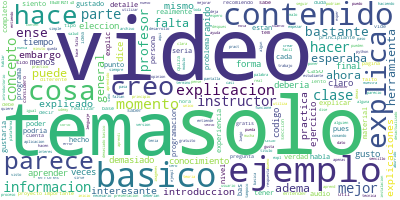

In [26]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list([' '.join(map(str, l)) for l in df_news['comment_cleaned']]))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()


Now we need to build the *corpus* and the *dictionary* that gensim need to work, to do that we need to pass a list of list of tokens

In [27]:
# las palabras "curso,clase" son stopwords

# MODELADO

Comparando:
Latent Dirichlet Allocation (LDA), 
Latent semantic analysis (LSA), 
Hierarchical Dirichlet Process (HDP)

Para evaluar los topics, usamos **topic coherence** (una medida de interpretación de topics).

https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

In [28]:
%%capture
!pip install pyLDAvis==2.1.2



In [29]:
%%capture
import pyLDAvis.gensim
pyLDAvis.enable_notebook()


In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot  as plt
from collections import Counter
import numpy as np
from nltk import word_tokenize, sent_tokenize
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords

import gensim
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim.models.ldamulticore import LdaMulticore
#from gensim.models.wrappers import LdaMallet
from gensim.corpora import Dictionary
from gensim import corpora

import pyLDAvis.gensim
pyLDAvis.enable_notebook()

import os, re, operator, warnings
warnings.filterwarnings('ignore')  
%matplotlib inline

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [31]:
# LDA MODEL

In [32]:
def display_topics(model, model_type="lda"):
    for topic_idx, topic in enumerate(model.print_topics()):
        print ("Topic %d:" % (topic_idx))
        if model_type== "hdp":
            print (" ".join(re.findall( r'\*(.[^\*-S]+).?', topic[1])), "\n")
        else:
            print (" ".join(re.findall( r'\"(.[^"]+).?', topic[1])), "\n")

Find out the optimal number of topics for the LDA model based on the coherence metric:

In [33]:
num_topics=10

###########
from gensim.test.utils import common_corpus, common_dictionary
from gensim.test.utils import datapath
from gensim.models.ldamodel import LdaModel
import shutil

# Load a potentially pretrained model from disk.
ldamodel = LdaModel.load("model/lda.model")

###########
# Print the fist 6 Keywords in the 10 topics
ldamodel.print_topics(num_topics, 5)


[(0,
  '0.018*"temas" + 0.017*"version" + 0.016*"informacion" + 0.015*"falta" + 0.014*"explicacion"'),
 (1,
  '0.018*"explicar" + 0.014*"paso" + 0.010*"explica" + 0.008*"hacer" + 0.008*"profesor"'),
 (2,
  '0.018*"creo" + 0.017*"basico" + 0.015*"ejemplos" + 0.014*"tema" + 0.013*"podria"'),
 (3,
  '0.021*"falta" + 0.017*"conceptos" + 0.012*"explica" + 0.012*"solo" + 0.010*"parte"'),
 (4,
  '0.036*"videos" + 0.025*"audio" + 0.015*"calidad" + 0.015*"video" + 0.014*"contenido"'),
 (5,
  '0.013*"profesor" + 0.013*"hace" + 0.012*"solo" + 0.010*"forma" + 0.008*"clases"'),
 (6,
  '0.016*"videos" + 0.015*"solo" + 0.014*"video" + 0.011*"puede" + 0.011*"ense"'),
 (7,
  '0.018*"solo" + 0.017*"basico" + 0.014*"ense" + 0.014*"eleccion" + 0.012*"parece"'),
 (8,
  '0.016*"contenido" + 0.014*"explicacion" + 0.013*"explica" + 0.013*"conceptos" + 0.013*"parece"'),
 (9,
  '0.046*"cosas" + 0.022*"explica" + 0.015*"explicar" + 0.013*"hace" + 0.011*"demasiado"')]

### Comparing the Model Coherence of the Best Models

we made 3 models, now let's compare each other's  coherence

In [34]:
ldatopics = [[word for word, prob in topic] for topicid, topic in ldamodel.show_topics(formatted=False)]

In [35]:
lda_coherence = CoherenceModel(topics=ldatopics, texts=df_news['comment_cleaned'].to_list(), dictionary=dictionary, window_size=10).get_coherence()
lda_coherence

NameError: ignored

In [36]:
display_topics(ldamodel)

Topic 0:
temas version informacion falta explicacion deberia ejemplos esperaba interesante gustaria 

Topic 1:
explicar paso explica hacer profesor proyecto ejemplo tener mejor solo 

Topic 2:
creo basico ejemplos tema podria nivel mejor solo conceptos ejemplo 

Topic 3:
falta conceptos explica solo parte ejercicios programacion basicos ejemplos creo 

Topic 4:
videos audio calidad video contenido informacion mejorar mejor explicacion parece 

Topic 5:
profesor hace solo forma clases basico mejor codigo conceptos temas 

Topic 6:
videos solo video puede ense momento contenido presentacion informacion visto 

Topic 7:
solo basico ense eleccion parece hacer instructor mejor introduccion linux 

Topic 8:
contenido explicacion explica conceptos parece habla tema tem introduccion falta 

Topic 9:
cosas explica explicar hace demasiado basico rapido hacer explicaciones aprender 



It looks like the topics are:
* Topic 0: felicitaciones
* Topic 1: expectativas
* Topic 2: experiencia
* Topic 3: contenido
* Topic 4: instructor
* Topic 5: material
* Topic 6: video
* Topic 7: lenguaje
* Topic 8: ejercicios
* Topic 9: titulo
* Topic 10: temas
* Topic 11: explicación


Let´s check the keyword when we selecting another number of topics (14)

# Classifiying all documents

now that we have been select the best model and topics number, is time to assign a topic to each document, means **cluster** according to the topics

In [37]:
dictionary = Dictionary.load("dictionary.dict")
corpus = [dictionary.doc2bow(text) for text in df_news['comment_cleaned'].to_list()]
corpus[232]

[(99, 1),
 (265, 1),
 (340, 1),
 (437, 1),
 (815, 2),
 (969, 1),
 (1048, 1),
 (1062, 1),
 (1063, 1),
 (1064, 1)]

In [46]:
len(corpus)

18883

In [40]:
unseen_doc = corpus[232]
print(unseen_doc)
vector = ldamodel[unseen_doc]  # get topic probability distribution for a document
print(vector)

[(99, 1), (265, 1), (340, 1), (437, 1), (815, 2), (969, 1), (1048, 1), (1062, 1), (1063, 1), (1064, 1)]
[(6, 0.7027087), (7, 0.23056851)]


In [80]:
from tqdm.notebook import tqdm_notebook

def format_topics_sentences(ldamodel=0, corpus=corpus, texts=0, texts_cleaned=0):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, rowX in tqdm_notebook(enumerate(corpus), total=len(corpus)):
        row = ldamodel[rowX]
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    
    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    contents = pd.Series(texts_cleaned)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)

    sent_topics_df.columns = ['Dominant_Topic_number', 'Perc_Contribution', 'Topic_Keywords', 'Text', 'Text_Cleaned']
    return(sent_topics_df)


#df_topic_sents_keywords = format_topics_sentences(ldamodel, doc_lda=doc_lda, texts=df_news['comment_cleaned'].to_list())
df_topic_sents_keywords = format_topics_sentences(ldamodel, corpus=corpus, texts=df_news['comment'].to_list(), texts_cleaned=df_news['comment_cleaned'].to_list())



  0%|          | 0/18883 [00:00<?, ?it/s]

In [83]:
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic_number', 'Topic_Perc_Contrib', 'Keywords', 'Text', 'Text_Cleaned']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic_number,Topic_Perc_Contrib,Keywords,Text,Text_Cleaned
0,0,7.00,0.59,"solo, basico, ense, eleccion, parece, hacer, instructor, mejor, introduccion, linux",como introducción esta bien pero deberían de hacerlo mas dirigido a RPA con fotos de RPAS,"[introduccion, deberian, hacerlo, dirigido, fotos, rp]"
1,1,8.00,0.55,"contenido, explicacion, explica, conceptos, parece, habla, tema, tem, introduccion, falta",Explican poco... se lee la mayoría,"[explican, mayori]"
2,2,4.00,0.63,"videos, audio, calidad, video, contenido, informacion, mejorar, mejor, explicacion, parece","es muy pronto para evaluarlo, comparandolo con la calidad de otros cursos este es bajo, no se pueden descargar los archivos ya que no estan en PDF y el sonido es malo, se escucha turbio.","[pronto, evaluarlo, comparandolo, calidad, bajo, pueden, descargar, archivos, estan, sonido, malo, escucha, turbi]"
3,3,2.00,0.46,"creo, basico, ejemplos, tema, podria, nivel, mejor, solo, conceptos, ejemplo","Excelente, muy detallado. Si fuera menos « leído » la calidad sería superior! El tema da para explicar más y leer menos","[detallado, menos, leido, calidad, seria, superior, tema, explicar, leer, men]"
4,4,8.00,0.55,"contenido, explicacion, explica, conceptos, parece, habla, tema, tem, introduccion, falta","Me parece que podria dar algun pequeño repaso de terminos comunes, ademas de dar mas ejemplos","[parece, podria, algun, peque, repaso, terminos, comunes, ademas, ejempl]"
5,5,5.00,0.60,"profesor, hace, solo, forma, clases, basico, mejor, codigo, conceptos, temas",Una parte del curso fue algo que el profesor mismo tiene en otro curso gratis.\nPero lo especializado a Hacking está igualmente bien explicado.,"[parte, profesor, mismo, gratis, especializado, hacking, igualmente, explic]"
6,6,6.00,0.60,"videos, solo, video, puede, ense, momento, contenido, presentacion, informacion, visto","No me gusto. Más que Hacking con Python... era aprende Python, de hacking poco y nada.","[gusto, hacking, python, aprende, python, hacking]"
7,7,6.00,0.57,"videos, solo, video, puede, ense, momento, contenido, presentacion, informacion, visto",habla de hacking y son dos apartados que solo son web. DECEPCIONANTE.,"[habla, hacking, apartados, solo, decepcion]"
8,8,0.00,0.40,"temas, version, informacion, falta, explicacion, deberia, ejemplos, esperaba, interesante, gustaria","Es una introducción breve y rápida al lenguaje de programación Python. No es un curso de Auditoria informática, ya que al final del curso se da un breve ejemplo de como hacer Scraping.No ha cumplido exactamente con mis expectativas pero he de reconocer que el tutor se ha esforzado e involucrado en los ejemplos del lenguaje.","[introduccion, breve, rapida, lenguaje, programacion, python, auditoria, informatica, final, breve, ejemplo, hacer, cumplido, exactamente, expectativas, reconocer, tutor, esforzado, involucrado, ejemplos, lenguaj]"
9,9,2.00,0.45,"creo, basico, ejemplos, tema, podria, nivel, mejor, solo, conceptos, ejemplo",Me pareció super bien el curso para las personas que quieran iniciarse en el lenguaje de programación python,"[parecio, super, personas, quieran, iniciarse, lenguaje, programacion, python]"


In [84]:
topic_nums=range(10)
for topic_num in topic_nums:
    print(topic_num)
    print(ldamodel.show_topic(topic_num))
    display(df_dominant_topic[df_dominant_topic["Dominant_Topic_number"]==topic_num].sort_values("Topic_Perc_Contrib",ascending=False)["Text"].head(4).tolist())
    print()

0
[('temas', 0.018332608), ('version', 0.016877582), ('informacion', 0.01576714), ('falta', 0.01454716), ('explicacion', 0.013653057), ('deberia', 0.011959253), ('ejemplos', 0.011419032), ('esperaba', 0.010760451), ('interesante', 0.009923366), ('gustaria', 0.009441767)]


['El curso es muy bueno, el profesor demuestra conocimiento pleno de los temas, sin embargo seria bueno que indique que archivo que se usará en cada clase principalmente al iniciar el curso y ser un poco mas ordenado.',
 'El curso cumple una función introductoria, lo cual no está mal, sin embargo considero que podría profundizar un poco más en algunos aspectos. Por otro lado, algunos de los datos para trabajar en arcmap tienen errores.',
 'Buen curso para iniciarse en el manejo de este framework sin embargo le falta el desarrollo de varios temas muy importantes co o la gestión de las sesiones de usuario entre otros.',
 'la informacion es bastante util,sin embargo, me gustaria se prefundisara un poco mas en ciertos aspectos. tener mas ejemplos de cada tema que se hable.']


1
[('explicar', 0.018331844), ('paso', 0.014123334), ('explica', 0.009632547), ('hacer', 0.008315461), ('profesor', 0.007847014), ('proyecto', 0.0074809357), ('ejemplo', 0.0072999876), ('tener', 0.007188237), ('mejor', 0.0070553795), ('solo', 0.006615273)]


['Explica bien pero no hay ejemplos de proyectos reales donde aplicar lo que enseña , lo cual se queda bastante cojo el curso.\nSi explica el justify-content que haga un mini proyecto de como se aplica ese concepto en una pagina web real.\nluego la propiedad flex: 1 0 dice que se omite la propiedad flex-shrink cuando no es así , el valor por defecto de flex-shrink es 1 lo cual el elemento hijo se queda igual por eso no hay modificación en el ancho de ese elemento.',
 'Muy buena explicación para iniciarse en el mundo de CSS, yo diría que la mejor forma de hacerlo, mas si se complementa con el curso de HTML del mismo Navis Code. Solo agregar que me hubiese gustado ver una sección para explicar brevemente que significa cada propiedad utilizada a lo largo del tutorial para que en la marcha se haga mas didáctico ver el avance con los proyectos 1 y 2. Lo demás excelente, nada que decir.',
 'Un desastre, aunque he sacado varias veces el 100% de las preguntas de pruebas, a la hora de la verdad


2
[('creo', 0.017740551), ('basico', 0.016996715), ('ejemplos', 0.015167167), ('tema', 0.0143293105), ('podria', 0.012605028), ('nivel', 0.010374517), ('mejor', 0.009211609), ('solo', 0.008764898), ('conceptos', 0.008283913), ('ejemplo', 0.0071921158)]


['Sí alguien va empezando por con la programación, al estar desactualizado el video con relación al Butterknife (que fue suplantado por ViewBinding) y al llegar al video del recurso en donde "explica" cómo tratar este cambio, es algo complicado. De igual forma, tiene otro video donde explica desde 0 cómo iniciar con Viewbinding, y creo que ese sería el video correcto al que debe redirigir',
 'Realmente no ayudó en nada, el título le queda demasiado grande; el nombre que yo le pondría sería: "Mi primera aplicación con Android (Primeros pasos)". Mostrar Android N como novedad es demasiado para este curso ya que no explican la importancia de las API\'s y la elección de estás.',
 'seria excelente una mejor explicacion, donde adquirir ciertos dispositivos, terminos o terminologia usada entre otros, uso de otros dispositivos y no exactamente el que el usa ya que no muchos tenemos acceso al dispositivo y no podemos poner en practica lo que se aprende.',
 'Cumplió con mis expectativas de apren


3
[('falta', 0.02112924), ('conceptos', 0.017165761), ('explica', 0.012150118), ('solo', 0.011533389), ('parte', 0.01031506), ('ejercicios', 0.009163799), ('programacion', 0.008761048), ('basicos', 0.0085406955), ('ejemplos', 0.008325609), ('creo', 0.007732302)]


['Siento que el curso está bastante desactualizado en lo que respecta a las herramientas que se utilizan para el hacking, ya que algunas están obsoletas o ya cambiaron sus términos de licencia y no se pueden explotar al 100%.\n\nAún así en lo que respecta a teoría si aclara bastante el panorama de cómo trabajan los hackers o cómo le hacen para llevar a cabo su "trabajo".',
 'Entre la oferta de cursos gratis me llamó la atención este curso, en un principio pensé que sería un curso para mejorar mi carrera profesional pero se trata de un curso que te educa para desarrollar tu actividad laboral cuidando tu salud.\n\nLo recomiendo aunque se me ha hecho un poco pesado, creo que es un cursillo muy útil si nos valoramos lo más minimo.\n\nPablo',
 'Hasta que llego al punto de los test perfecto. Buena refactorización y trucos. La explicación de como implementar los test nula. No entiendo nada en el primer test del endpoint Get. Da por hecho que sabemos lo que hay que hacer con JEST pero no tengo


4
[('videos', 0.03557409), ('audio', 0.025063245), ('calidad', 0.015417595), ('video', 0.014812847), ('contenido', 0.013712426), ('informacion', 0.012223801), ('mejorar', 0.011098064), ('mejor', 0.010130064), ('explicacion', 0.0091609005), ('parece', 0.008742268)]


['Falta mas seriedad del instructor, dice mucho " eh, eh, eh, perdon, eh, eh, perdon." no es seguro de si mismo, demuestra duda y falta de conocimiento. y ademas la fuente  de información es de wikipedia, son fuente dudosa, que cualquiera puede editar y agregar cualquier cosa. debe ser fuente confiable. wikipedia no puede ser fuente de información para un curso que dice ser serio.',
 'Este curso estaría mejor si se hubiera sido subtitulado (como las peliculas) el instructor a pesar sus buenas intenciones, se pierde al dar explicaciones y creo que hace más largos los videos de lo que en realidad deberían de ser, se ve que no tenia un guión preparado, esto deriva en que el instructor tiene una "muletilla" deseperante que esta en la mayoría de las lecciones que vi, es un "ehh, ehh, ehh" como si pensara que decir.\nAdemás juro que escuche ladrar perros y personas hablaban en el fondo. En fin.',
 'Definitivamente esto es una recopilación de videos de YouTube, no estoy seguro si Udemy es la 


5
[('profesor', 0.012601818), ('hace', 0.012521222), ('solo', 0.012320195), ('forma', 0.009869721), ('clases', 0.008016671), ('basico', 0.007745398), ('mejor', 0.0066153915), ('codigo', 0.0064034085), ('conceptos', 0.006386699), ('temas', 0.0060220626)]


['Primero de todo el titulo es un poco engañoso. Que el curso se llame master en machine learning que es lo que me interesaba y realmente no se vea nada de machine learning ha sido un poco decepcionante. Al principio era en plan veremos como limpiar datos, veremos como aplicarlo a machine learning, etc y por ello me quede hasta el final (aunque por el temario de curso no me diese esa impresión, pero bueno dije al principio hará un repaso de los lenguajes y se irá acercando más como decía al principio).\nEl segundo punto es que encuentro que el curso no está conexo. Es decir que veo que al final se ha ordenado de otra forma. Da la impresión que por los comentarios, primero tuviese que ir todo lo de R y luego todo lo de Python. Además a veces oías algo del estilo "como vimos al final de la unidad anterior" cuando a lo mejor hace dos temas que lo vimos o por ejemplo en la unidad 65 (La estadística, la base para\ncualquier analista de datos) es como si fuese sacado de otro curso porque al 


6
[('videos', 0.015525432), ('solo', 0.014996568), ('video', 0.0136888735), ('puede', 0.0106143), ('ense', 0.010544723), ('momento', 0.009770916), ('contenido', 0.009030324), ('presentacion', 0.008603166), ('informacion', 0.008364057), ('visto', 0.007891148)]


['empezando por que no se llama como el curso en el que yo me matriculé, y eso no crea confianza. Yo me matriculé de Teledetección, y a pesar de que el temario pueda ser compartido o incluso igual, estoy haciendo un curso que no se llama así. Los últimos 10 ó 12 módulos que he visto son todos iguales, duran 2 minutos y tras repetir lo mismo al inicio y al final, te queda 1 minuto de video, cuya metodología se repite. Las combinaciones de bandas y la interpretación se puede exponer de una manera mucho más aprovechable para el alumno.',
 'Las explicaciones son muy claras, sin embargo, creo que el alcance de lo que se puede hacer con la información es muy limitado. Ejemplo: únicamente mercancías livianas, con proveedores que manejen DDP y sólo mediante transporte aéreo. Ya mejor díganme que sólo puedo importar funkos.',
 'al ingresar al primer modulo, se nos indica leer un artículo en una página web de un periódico de Colombia, pues el vínculo no existe y te lleva  a la misma página, ofre


7
[('solo', 0.018478401), ('basico', 0.016931616), ('ense', 0.01383008), ('eleccion', 0.013503557), ('parece', 0.011532184), ('hacer', 0.011314513), ('instructor', 0.009742705), ('mejor', 0.009032673), ('introduccion', 0.007768075), ('linux', 0.0076965434)]


["So far it's been a very enjoyable course, I like it.\n\nI understand that this introductory course consists of a summary which in turn consists of some videos of the other courses of the same author. \n\nHowever, it is a bit annoying that it alludes to videos that are not part of this one, particularly when it talks about the video about sharpening formones that is not included in this course. On the other hand, the final video of the finishes has nothing to do, the only justification I find for its inclusion in this course is because at the end promotes some more advanced work and courses.\n\nFor the rest, I reaffirm what I said at the beginning.",
 "I'd like to be honest with you my friend, I think you have the right idea but it isn't implemented in a good way, you don't need to repeat the words during the video, because it's monotonous, I think you could simulate situations of the real life and it'll be more interesting. Great project.",
 'Things to improve: \n-Some times (not man


8
[('contenido', 0.015695354), ('explicacion', 0.013638228), ('explica', 0.013353598), ('conceptos', 0.013214575), ('parece', 0.012901588), ('habla', 0.010801068), ('tema', 0.010662903), ('tem', 0.009797305), ('introduccion', 0.009106276), ('falta', 0.008676541)]


['En primer lugar, me parece un curso útil, que traza algunas líneas del marketing online.\nSin embargo, considero que las explicaciones se quedan faltas de contenido, que los ejemplos en muchos casos son pobres y que algunas de las expresiones utilizadas no son fáciles de comprender.\nA pesar de todo, gracias por su curso.\nUn saludo.',
 'Es muy desmotivante ver que el tutor hace varios meses no responde las inquietudes de sus alumnos, las explicaciones son demasiado cortas , y no explica bien como es el manejo de los futuros.\nEn lo referente al psicotrading deja mucho que desear.\n\nRealmente tenia una mejor expectativa del curso',
 'La explicacion muchas veces es poco clara debido a la forma de expresarse del docente. \nAdemas habla demasiado rapido por ser un curso "basico" y se mueve demasiado rapidamente con el cursor dando "por hecho" muchos aspectos que no los son para un principiante',
 'El contenido es claro e interesante, ya he tomado un par de cursos con Fabian y me han si


9
[('cosas', 0.046243057), ('explica', 0.021627026), ('explicar', 0.015366635), ('hace', 0.013491512), ('demasiado', 0.010975455), ('basico', 0.010664554), ('rapido', 0.009499844), ('hacer', 0.009072226), ('explicaciones', 0.008533129), ('aprender', 0.008357799)]


['El curso está bien para iniciarse en Unity y echarle una tarde viendo funcionalidades básicas... Pero está incompleto, no haces más que diseñar un nivel, una moneda y para casa. Si quieres hacer el juego final tienes que hacer otro curso de pago. Como digo, un poco inutil hacer este curso, pero si nunca has tocado Unity sacas una idea muy superficial de como funciona.',
 'Es un buen curso para empezar, aprendes varias cosas pero no es un curso completo sobre ASP.NET MVC. Aunque explica varios temas importantes la verdad es que se dedica mucho a crear proyectos y explicar que fue lo que creo el Framework. Lo recomiendo si eres una persona que se esta iniciando en el desarrollo web pero si no es el caso no creo que vallas a aprender nada nuevo.',
 'El curso se titula: mi primer juego con unity 5. Pensé que se iba a realizar el juego completo y no solo el diseño. De todas formas me gustó ver este curso gratuito pues es la primera vez que toco Unity y me ayudó mucho a la hora de interact

In [85]:
topic_vec = np.array([0] * num_topics) 
print(topic_vec)
topic_vec[0]=10
print(topic_vec)


[0 0 0 0 0 0 0 0 0 0]
[10  0  0  0  0  0  0  0  0  0]


In [86]:
from tqdm import tqdm_notebook

#corpus_i = corpus[1000]
corp_list = []
for ii,unseen_doc in tqdm_notebook(enumerate(corpus), 
                         total=len(corpus), 
                         desc="Processing records"):
  #top_topics = (lda_model.get_document_topics(corp_ii,
  #                                      minimum_probability=0.0)
  #)
  #topic_vec = [top_topics[i][1] if top_topics[i][1]>0.1 else 0 for i in range(num_topics)]
  doc_lda_ii = ldamodel[unseen_doc]
  topic_vec = [0] * num_topics
  for yy,zz in doc_lda_ii:
    #if zz>0.1:
      topic_vec[yy] = zz

  corp_list.append(topic_vec)

Processing records:   0%|          | 0/18883 [00:00<?, ?it/s]

## Análisis de topicos

In [87]:
dg_topics = pd.DataFrame(corp_list)
dg_topics.tail(10)

,0,1,2,3,4,5,6,7,8,9
18873,0.00,0.00,0.00,0.00,0.82,0.00,0.00,0.00,0.00,0.00
18874,0.00,0.00,0.00,0.82,0.00,0.00,0.00,0.00,0.00,0.00
18875,0.00,0.53,0.00,0.00,0.00,0.00,0.00,0.00,0.31,0.00
18876,0.00,0.00,0.28,0.00,0.23,0.33,0.00,0.15,0.00,0.00
18877,0.70,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
18878,0.00,0.77,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
18879,0.00,0.00,0.19,0.00,0.59,0.00,0.16,0.00,0.00,0.00
18880,0.00,0.00,0.41,0.00,0.00,0.00,0.39,0.00,0.00,0.00
18881,0.00,0.00,0.00,0.00,0.66,0.00,0.00,0.00,0.23,0.00
18882,0.00,0.00,0.00,0.87,0.00,0.00,0.00,0.00,0.00,0.00


In [88]:
df_all = pd.merge(df_news, dg_topics.add_prefix('topic_'), left_index=True, right_index=True,)
df_all.tail()

,index,id,course,rating,comment,user,tag,comment_cleaned,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
18878,174120,44039526,2241124,1.50,El video de corta cada 30 segundos,Marcelo Vergara,neg,"[video, corta, cada, segund]",0.00,0.77,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
18879,174124,42312208,2241124,3.50,"Aplica el sentido común.La experiencia que aporta . Puntos claves para saber emprender. Características del vendedor, honestidad, claridad, confianza, querer Vender.",Jose Manuel Torres Segade,neg,"[aplica, comu, experiencia, aporta, puntos, claves, saber, emprender, caracteristicas, vendedor, honestidad, claridad, confianza, querer, vend]",0.00,0.00,0.19,0.00,0.59,0.00,0.16,0.00,0.00,0.00
18880,174126,40788704,2241124,3.00,"Creí que podía ser mas completo, pero me equivoqué",Cristian Vera,neg,"[crei, podia, completo, equivoqu]",0.00,0.00,0.41,0.00,0.00,0.00,0.39,0.00,0.00,0.00
18881,174137,34694642,2241124,3.50,El contenido es breve y muy bueno para quienes se inician como asesores inmobiliarios. Los videos son de regular calidad.,Lourdes Gallardo,neg,"[contenido, breve, inician, asesores, inmobiliarios, videos, regular, cal]",0.00,0.00,0.00,0.00,0.66,0.00,0.00,0.00,0.23,0.00
18882,174140,93644240,3202322,3.00,"Solo se explica la conexión web, sería lo suyo explicar la app descargada.",Janira Cumbajin,neg,"[solo, explica, conexion, seria, explicar, descarg]",0.00,0.00,0.00,0.87,0.00,0.00,0.00,0.00,0.00,0.00


In [89]:
len(df_news),len(dg_topics), len(df_all)

(18883, 18883, 18883)

In [91]:
df_all.to_csv("udemy_reviews_with_topics.csv.zip", 
           index=False, 
           compression="zip")


In [92]:
dg_topics.sum(axis=1).sample(10)

5125    0.89
11821   0.70
306     0.70
7577    0.93
4077    0.87
354     0.70
13370   0.80
16147   0.95
13121   0.73
15095   0.91
dtype: float64

In [93]:
((dg_topics.astype(bool)==False).sum(axis=1)==num_topics).sum()

0

In [94]:
len(dg_topics)

18883

<BarContainer object of 10 artists>

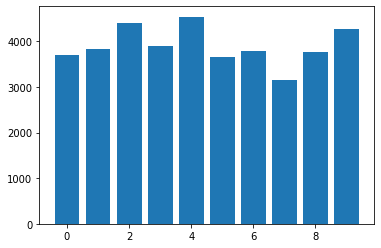

In [95]:
import matplotlib.pyplot as plt
plt.bar(dg_topics.columns, dg_topics.astype(bool).sum())

<BarContainer object of 10 artists>

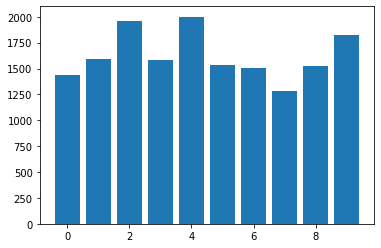

In [96]:
import matplotlib.pyplot as plt
plt.bar(dg_topics.columns, dg_topics.sum())

We selected the ldamodel with 12 topics and asigned a dominant topic to each document, now let map each topic with a label 

first let's create the dictionary

In [97]:
label_dicc = {0:'felicitaciones', 1:'expectativas', 2:'experiencia', 3: 'contenido', 4:'instructor', 5:'material', 6:'video', 
              7:'lenguaje', 8:'ejercicios', 9: 'titulo', 10:'temas', 11:'explicación'}

label_dicc = {0:"1_muy_introductorio",
1:"2_faltan_explicaciones",
2:"3_poco_preciso",
3:"4_falta_práctica",
4:"5_video_y_audio",
5:"6_dificil_de_seguir",
6:"7_nada",
7:"8_comentario_incomprensible",
8:"9_poco_claro",
9:"10_muy_superficial",
}

In [98]:
df_dominant_topic['Dominant_Topic_number'] = df_dominant_topic['Dominant_Topic_number'].astype('int64')

In [99]:
df_dominant_topic['Dominant_Topic'] = df_dominant_topic['Dominant_Topic_number'].map(label_dicc)

df_dominant_topic.to_csv("udemy_reviews_dominant.csv.zip", 
           index=False, 
           compression="zip")

df_dominant_topic.sample(10)

,Document_No,Dominant_Topic_number,Topic_Perc_Contrib,Keywords,Text,Text_Cleaned,Dominant_Topic
2526,2526,2,0.45,"creo, basico, ejemplos, tema, podria, nivel, mejor, solo, conceptos, ejemplo","No uso ningun ejemplo practico, me refiero a que no se hizo un ejemplo con javascript, si no que lo hizo en java. Ademas al inicio mencionastes que spring reactor, te permite ser cancelables los flujos, pero no hicistes ningun caso practico con eso y yo vino justamente por eso.","[ningun, ejemplo, practico, refiero, hizo, ejemplo, javascript, hizo, java, ademas, inicio, mencionastes, spring, reactor, permite, cancelables, flujos, hicistes, ningun, caso, practico, vino, just]",3_poco_preciso
4586,4586,5,0.51,"profesor, hace, solo, forma, clases, basico, mejor, codigo, conceptos, temas","Buena explicación y transmite positivismo para afrontar los futuros desafíos del curso, pero al avanzar el curso me he dado cuenta que las explicaciones son solo a nivel general, no hay ejercicios de referencia, y por ende, no hay explicación estructurada de cada sección del ejercicio. \nAl final agrega un pdf con ejercicios, pero solo realiza las consultas, no se logran resolver con las explicaciones dadas, porque no existe información suficiente.","[buena, explicacion, transmite, positivismo, afrontar, futuros, desafios, avanzar, dado, cuenta, explicaciones, solo, nivel, general, ejercicios, referencia, ende, explicacion, estructurada, cada, seccion, ejercicio, final, agrega, ejercicios, solo, realiza, consultas, logran, resolver, explicaciones, dadas, existe, informacion, suficient]",6_dificil_de_seguir
14772,14772,1,0.85,"explicar, paso, explica, hacer, profesor, proyecto, ejemplo, tener, mejor, solo",No termina video de pong para que quede igual al inicial,"[termina, video, pong, quede, igual, inicial]",2_faltan_explicaciones
2960,2960,2,0.90,"creo, basico, ejemplos, tema, podria, nivel, mejor, solo, conceptos, ejemplo","Muchísima teoría y poca práctica, realmente esperaba más. En lo personal no me ayudo en nada.","[muchisima, teoria, poca, practica, realmente, esperaba, personal, ayud]",3_poco_preciso
16027,16027,2,0.89,"creo, basico, ejemplos, tema, podria, nivel, mejor, solo, conceptos, ejemplo","Intuye que se tiene conocimiento básico del tema, no explica detalladamente, es difícil comprender la infomarción","[intuye, conocimiento, basico, tema, explica, detalladamente, dificil, comprender, infomarcion]",3_poco_preciso
7952,7952,9,0.42,"cosas, explica, explicar, hace, demasiado, basico, rapido, hacer, explicaciones, aprender",Great A++++\nMuy Bueno He aprendido muchos en estos dias.,"[great, bueno, aprendido, di]",10_muy_superficial
3672,3672,6,0.93,"videos, solo, video, puede, ense, momento, contenido, presentacion, informacion, visto","Hasta el momento solo he visto la intro que es información que ya esta en la pagina oficial de Andoid, espero se ponga mejor al comenzar con el codigo.","[momento, solo, visto, intro, informacion, pagina, oficial, andoid, espero, ponga, mejor, comenzar, codig]",7_nada
12435,12435,9,0.77,"cosas, explica, explicar, hace, demasiado, basico, rapido, hacer, explicaciones, aprender",muy bien aprendi tips que no sabia,"[aprendi, tips, sabi]",10_muy_superficial
4096,4096,8,0.55,"contenido, explicacion, explica, conceptos, parece, habla, tema, tem, introduccion, falta","Me interesa mucho el tema en cuestión, aun me faltan otras secciones, pero hay pequeños detalles que para principiantes deberian detallarse o ejemplificarse un poco mas","[interesa, tema, cuestion, faltan, secciones, peque, detalles, principiantes, deberian, detallarse, ejemplific]",9_poco_claro
17165,17165,5,0.87,"profesor, hace, solo, forma, clases, basico, mejor, codigo, conceptos, temas","Al ejecutar me sale error running 'app' no target device found, y pues dificil porque no sé que hacer","[ejecutar, sale, error, running, target, device, found, pues, dificil, hac]",6_dificil_de_seguir


In [100]:
df_dominant_topic.isna().sum()

Document_No              0
Dominant_Topic_number    0
Topic_Perc_Contrib       0
Keywords                 0
Text                     0
Text_Cleaned             0
Dominant_Topic           0
dtype: int64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe1fe4d96d0>],
      dtype=object)

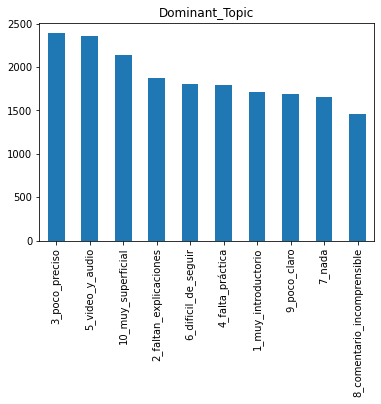

In [101]:
df_dominant_topic['Dominant_Topic'].value_counts().plot(kind='bar', subplots=True)

In [102]:
df_dominant_filtered.sample(10)

,Dominant_Topic,Text
15517,8_comentario_incomprensible,libere algunas cuerdas que me tenían amarrado con la lógica
17318,8_comentario_incomprensible,"The author does not know how to teach. Boring leassons, not going to the point, bad pronuntiation. Horrible. I'd not recommend this to anyone."
4685,8_comentario_incomprensible,todavia no me quedan claro muchas cosas
3749,8_comentario_incomprensible,"Creo que es necesario hacer una presentación del GUI más acabada, se me borran barras de herramientas y no sé como volverlas, se me cierran algunas vistas y no las encuentro más por que no sé donde están."
4513,8_comentario_incomprensible,"Es muy técnico. Soy un beginner total y absolut, así que tengo que mirarme los videos muy detenidamente y mi progreso es muy lento."
12143,8_comentario_incomprensible,Buena Eleccion Estoy Aprendiendo Cosas Las Cuales Se Me Complicaban Un Poco
7505,8_comentario_incomprensible,"Good to know the essence, I would want more input from interlocutor besides reading"
2775,8_comentario_incomprensible,apenas empiezo pero si creo que sea una buena elección
1621,8_comentario_incomprensible,faltaría explicar como instalar en un Windows home o por lo menos enviarlo al foro de msdn
16028,8_comentario_incomprensible,No me gusto el curso el instructor solo se dedico a hacer copia y pega


,Dominant_Topic,Text,Text_Cleaned
11786,10_muy_superficial,"El curso está bien para iniciarse en Unity y echarle una tarde viendo funcionalidades básicas... Pero está incompleto, no haces más que diseñar un nivel, una moneda y para casa. Si quieres hacer el juego final tienes que hacer otro curso de pago. Como digo, un poco inutil hacer este curso, pero si nunca has tocado Unity sacas una idea muy superficial de como funciona.","[iniciarse, unity, echarle, tarde, viendo, funcionalidades, basicas, incompleto, haces, dise, nivel, moneda, casa, quieres, hacer, juego, final, hacer, pago, digo, inutil, hacer, nunca, tocado, unity, sacas, idea, superficial, funcion]"
3294,10_muy_superficial,"Es un buen curso para empezar, aprendes varias cosas pero no es un curso completo sobre ASP.NET MVC. Aunque explica varios temas importantes la verdad es que se dedica mucho a crear proyectos y explicar que fue lo que creo el Framework. Lo recomiendo si eres una persona que se esta iniciando en el desarrollo web pero si no es el caso no creo que vallas a aprender nada nuevo.","[empezar, aprendes, varias, cosas, completo, explica, varios, temas, importantes, verdad, dedica, crear, proyectos, explicar, creo, framework, recomiendo, persona, iniciando, desarrollo, caso, creo, vallas, aprender, nuev]"
11806,10_muy_superficial,El curso se titula: mi primer juego con unity 5. Pensé que se iba a realizar el juego completo y no solo el diseño. De todas formas me gustó ver este curso gratuito pues es la primera vez que toco Unity y me ayudó mucho a la hora de interactuar con la herramienta.,"[titula, primer, juego, unity, pense, realizar, juego, completo, solo, dise, todas, formas, gusto, gratuito, pues, primera, toco, unity, ayudo, hora, interactuar, herramient]"


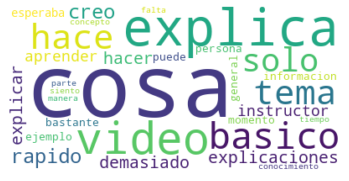

,Dominant_Topic,Text,Text_Cleaned
601,1_muy_introductorio,"El curso es muy bueno, el profesor demuestra conocimiento pleno de los temas, sin embargo seria bueno que indique que archivo que se usará en cada clase principalmente al iniciar el curso y ser un poco mas ordenado.","[profesor, demuestra, conocimiento, pleno, temas, embargo, seria, indique, archivo, usara, cada, clase, principalmente, iniciar, orden]"
1551,1_muy_introductorio,"El curso cumple una función introductoria, lo cual no está mal, sin embargo considero que podría profundizar un poco más en algunos aspectos. Por otro lado, algunos de los datos para trabajar en arcmap tienen errores.","[cumple, funcion, introductoria, embargo, considero, podria, profundizar, aspectos, lado, datos, trabajar, arcmap, error]"
12205,1_muy_introductorio,Buen curso para iniciarse en el manejo de este framework sin embargo le falta el desarrollo de varios temas muy importantes co o la gestión de las sesiones de usuario entre otros.,"[iniciarse, manejo, framework, embargo, falta, desarrollo, varios, temas, importantes, gestion, sesiones, usuari]"


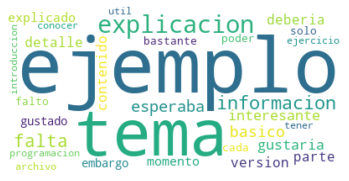

,Dominant_Topic,Text,Text_Cleaned
11707,2_faltan_explicaciones,"Explica bien pero no hay ejemplos de proyectos reales donde aplicar lo que enseña , lo cual se queda bastante cojo el curso.\nSi explica el justify-content que haga un mini proyecto de como se aplica ese concepto en una pagina web real.\nluego la propiedad flex: 1 0 dice que se omite la propiedad flex-shrink cuando no es así , el valor por defecto de flex-shrink es 1 lo cual el elemento hijo se queda igual por eso no hay modificación en el ancho de ese elemento.","[explica, ejemplos, proyectos, reales, aplicar, ense, queda, bastante, cojo, explica, justify, content, haga, mini, proyecto, aplica, concepto, pagina, real, luego, propiedad, flex, dice, omite, propiedad, flex, shrink, valor, defecto, flex, shrink, elemento, hijo, queda, igual, modificacion, ancho, element]"
17397,2_faltan_explicaciones,"Muy buena explicación para iniciarse en el mundo de CSS, yo diría que la mejor forma de hacerlo, mas si se complementa con el curso de HTML del mismo Navis Code. Solo agregar que me hubiese gustado ver una sección para explicar brevemente que significa cada propiedad utilizada a lo largo del tutorial para que en la marcha se haga mas didáctico ver el avance con los proyectos 1 y 2. Lo demás excelente, nada que decir.","[explicacion, iniciarse, mundo, diria, mejor, forma, hacerlo, complementa, html, mismo, navis, code, solo, agregar, gustado, seccion, explicar, brevemente, significa, cada, propiedad, utilizada, largo, tutorial, marcha, haga, didactico, avance, proyectos, demas, dec]"
483,2_faltan_explicaciones,"Un desastre, aunque he sacado varias veces el 100% de las preguntas de pruebas, a la hora de la verdad ni se parecen a las del examen real. Como no se actualice este curso es poco útil para el examen actual. Cierto es que las preguntas de ejemplo que vienen con el programa oficial tampoco se parecen al examen actual. Hay algo que no se ha actualizado debidamente","[desastre, sacado, varias, veces, preguntas, pruebas, hora, verdad, parecen, examen, real, actualice, util, examen, actual, cierto, preguntas, ejemplo, vienen, programa, oficial, tampoco, parecen, examen, actual, actualizado, debid]"


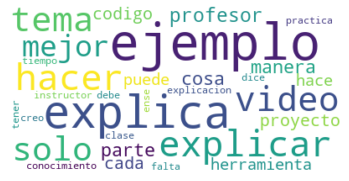

,Dominant_Topic,Text,Text_Cleaned
17152,3_poco_preciso,"Sí alguien va empezando por con la programación, al estar desactualizado el video con relación al Butterknife (que fue suplantado por ViewBinding) y al llegar al video del recurso en donde ""explica"" cómo tratar este cambio, es algo complicado. De igual forma, tiene otro video donde explica desde 0 cómo iniciar con Viewbinding, y creo que ese sería el video correcto al que debe redirigir","[alguien, empezando, programacion, desactualizado, video, relacion, butterknife, suplantado, viewbinding, llegar, video, explica, tratar, cambio, complicado, igual, forma, video, explica, iniciar, viewbinding, creo, seria, video, correcto, debe, redirig]"
18335,3_poco_preciso,"Realmente no ayudó en nada, el título le queda demasiado grande; el nombre que yo le pondría sería: ""Mi primera aplicación con Android (Primeros pasos)"". Mostrar Android N como novedad es demasiado para este curso ya que no explican la importancia de las API's y la elección de estás.","[realmente, ayudo, titulo, queda, demasiado, grande, nombre, pondria, seria, primera, aplicacion, android, primeros, pasos, mostrar, android, novedad, demasiado, explican, importancia, eleccion]"
2522,3_poco_preciso,"seria excelente una mejor explicacion, donde adquirir ciertos dispositivos, terminos o terminologia usada entre otros, uso de otros dispositivos y no exactamente el que el usa ya que no muchos tenemos acceso al dispositivo y no podemos poner en practica lo que se aprende.","[seria, mejor, explicacion, adquirir, ciertos, dispositivos, terminos, terminologia, usada, dispositivos, exactamente, acceso, dispositivo, podemos, poner, practica, aprend]"


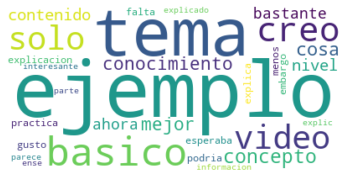

,Dominant_Topic,Text,Text_Cleaned
804,4_falta_práctica,"Siento que el curso está bastante desactualizado en lo que respecta a las herramientas que se utilizan para el hacking, ya que algunas están obsoletas o ya cambiaron sus términos de licencia y no se pueden explotar al 100%.\n\nAún así en lo que respecta a teoría si aclara bastante el panorama de cómo trabajan los hackers o cómo le hacen para llevar a cabo su ""trabajo"".","[siento, bastante, desactualizado, respecta, herramientas, utilizan, hacking, estan, obsoletas, cambiaron, terminos, licencia, pueden, explotar, respecta, teoria, aclara, bastante, panorama, trabajan, hackers, hacen, llevar, cabo, trabaj]"
13063,4_falta_práctica,"Entre la oferta de cursos gratis me llamó la atención este curso, en un principio pensé que sería un curso para mejorar mi carrera profesional pero se trata de un curso que te educa para desarrollar tu actividad laboral cuidando tu salud.\n\nLo recomiendo aunque se me ha hecho un poco pesado, creo que es un cursillo muy útil si nos valoramos lo más minimo.\n\nPablo","[oferta, gratis, llamo, atencion, principio, pense, seria, mejorar, carrera, profesional, trata, educa, desarrollar, actividad, laboral, cuidando, salud, recomiendo, hecho, pesado, creo, cursillo, util, valoramos, minimo, pabl]"
3166,4_falta_práctica,Hasta que llego al punto de los test perfecto. Buena refactorización y trucos. La explicación de como implementar los test nula. No entiendo nada en el primer test del endpoint Get. Da por hecho que sabemos lo que hay que hacer con JEST pero no tengo ni idea de lo que está explicando. \n\nGracias de todas formas,"[llego, punto, test, perfecto, buena, refactorizacion, trucos, explicacion, implementar, test, nula, entiendo, primer, test, endpoint, hecho, sabemos, hacer, jest, idea, explicando, todas, form]"


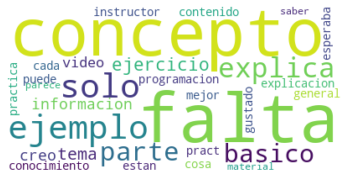

,Dominant_Topic,Text,Text_Cleaned
7271,5_video_y_audio,"Falta mas seriedad del instructor, dice mucho "" eh, eh, eh, perdon, eh, eh, perdon."" no es seguro de si mismo, demuestra duda y falta de conocimiento. y ademas la fuente de información es de wikipedia, son fuente dudosa, que cualquiera puede editar y agregar cualquier cosa. debe ser fuente confiable. wikipedia no puede ser fuente de información para un curso que dice ser serio.","[falta, seriedad, instructor, dice, perdon, perdon, seguro, mismo, demuestra, duda, falta, conocimiento, ademas, fuente, informacion, wikipedia, fuente, dudosa, cualquiera, puede, editar, agregar, cualquier, cosa, debe, fuente, confiable, wikipedia, puede, fuente, informacion, dice, seri]"
4503,5_video_y_audio,"Este curso estaría mejor si se hubiera sido subtitulado (como las peliculas) el instructor a pesar sus buenas intenciones, se pierde al dar explicaciones y creo que hace más largos los videos de lo que en realidad deberían de ser, se ve que no tenia un guión preparado, esto deriva en que el instructor tiene una ""muletilla"" deseperante que esta en la mayoría de las lecciones que vi, es un ""ehh, ehh, ehh"" como si pensara que decir.\nAdemás juro que escuche ladrar perros y personas hablaban en el fondo. En fin.","[estaria, mejor, sido, subtitulado, peliculas, instructor, pesar, intenciones, pierde, explicaciones, creo, hace, largos, videos, realidad, deberian, tenia, guion, preparado, deriva, instructor, muletilla, deseperante, mayoria, lecciones, pensara, decir, ademas, juro, escuche, ladrar, perros, personas, hablaban, fond]"
18866,5_video_y_audio,"Definitivamente esto es una recopilación de videos de YouTube, no estoy seguro si Udemy es la plataforma ideal, aquí se viene a tomar cursos y a aprender no a ver publicidad de Solange Candelo y su empresa Realtaria, tiene poca información útil como curso pero las partes en las que los agentes inmobiliarios hablan de por qué Realtaria es una buena empresa no me interesa en lo absoluto, deberian quitarlo, en fin, no me puedo quejar ya que la poca información pues es gratis.","[definitivamente, recopilacion, videos, youtube, seguro, udemy, plataforma, ideal, aqui, viene, tomar, aprender, publicidad, solange, candelo, empresa, realtaria, poca, informacion, util, partes, agentes, inmobiliarios, hablan, realtaria, empresa, interesa, absoluto, deberian, quitarlo, puedo, quejar, poca, informacion, pues, gratis]"


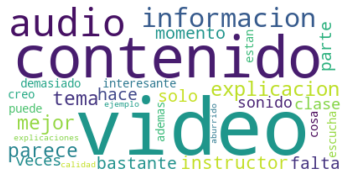

,Dominant_Topic,Text,Text_Cleaned
12421,6_dificil_de_seguir,"Primero de todo el titulo es un poco engañoso. Que el curso se llame master en machine learning que es lo que me interesaba y realmente no se vea nada de machine learning ha sido un poco decepcionante. Al principio era en plan veremos como limpiar datos, veremos como aplicarlo a machine learning, etc y por ello me quede hasta el final (aunque por el temario de curso no me diese esa impresión, pero bueno dije al principio hará un repaso de los lenguajes y se irá acercando más como decía al principio).\nEl segundo punto es que encuentro que el curso no está conexo. Es decir que veo que al final se ha ordenado de otra forma. Da la impresión que por los comentarios, primero tuviese que ir todo lo de R y luego todo lo de Python. Además a veces oías algo del estilo ""como vimos al final de la unidad anterior"" cuando a lo mejor hace dos temas que lo vimos o por ejemplo en la unidad 65 (La estadística, la base para\ncualquier analista de datos) es como si fuese sacado de otro curso porque al iniciar el video en el video se aprecian cosas tipo summary(data$mpg) o str(data$cylinders) que no lo hemos visto y empieza diciendo ""como acabamos de ver"". Dices bueno esto no tendrá importancia, lo que requiere es lo que vendrá a continuación. Pero ves que no, que como datos usa data$mpg que no sabemos ni como se obtiene, si mediante paquete o ese data y ese mpg viene de alguna instrucción o de donde. \nEl tercer punto y algo más positivo, es que a pesar de esto, me pareció que supo explicar muy bien tanto en el video como en el material proporcionado y poner unos ejemplos sencillos y claros. Es por esta parte que añadí la media estrella más, pero si no iba de cabeza a la estrella por todo lo comentado al principio que sinceramente me ha decepcionado mucho","[primero, titulo, enga, llame, master, machine, learning, interesaba, realmente, machine, learning, sido, decepcionante, principio, plan, veremos, limpiar, datos, veremos, aplicarlo, machine, learning, ello, quede, final, temario, diese, impresion, dije, principio, hara, repaso, lenguajes, acercando, decia, principio, segundo, punto, encuentro, conexo, decir, final, ordenado, forma, impresion, comentarios, primero, luego, python, ademas, veces, oias, estilo, vimos, final, unidad, anterior, mejor, hace, temas, vimos, ejemplo, unidad, estadistica, base, paracualquier, analista, datos, sacado, iniciar, video, video, aprecian, cosas, tipo, summary, data, data, cylinders, visto, empieza, diciendo, acabamos, dices, tendra, importancia, requiere, vendra, continuacion, datos, data, sabemos, obtiene, mediante, paquete, data, viene, alguna, instruccion, tercer, ...]"
509,6_dificil_de_seguir,"Comparada con los cursos de Logali, este da la impresión de estar menos preparado, trata de explicar los temas pero tiene que ir resolviendo incidentes conforme se desarrolla el curso. Es bueno, pero muy corto; para la amplia gama de cosas nuevas del abap 7.4 esta muy limitado. Además, insisto, si se tiene la referencia de los cursos de Logali, a este le falta mas forma y estructura. Revisen el curso de POO ABAP de Logali, diapositivas animadas, curso preparado de inicio a fin, ejemplos claro, precisos y sin error. La verdad, estoy muy decepcionado de lo que pague.","[comparada, logali, impresion, menos, preparado, trata, explicar, temas, resolviendo, incidentes, conforme, desarrolla, corto, amplia, gama, cosas, nuevas, abap, limitado, ademas, insisto, referencia, logali, falta, forma, estructura, revisen, abap, logali, diapositivas, animadas, preparado, inicio, ejemplos, claro, precisos, error, verdad, decepcionado, pag]"
2809,6_dificil_de_seguir,"Quiero agradecer por tan valiosa información, en mi caso el Estudio del idioma Ingles no se meda de forma natural y fácil, pero ahora que escucho la profesora ANNA me trasmitió tanta pasión y positivismo que estoy deseosa de iniciar y poder llegar al final con muy buenos resultados.\nGracias profesora Anna 

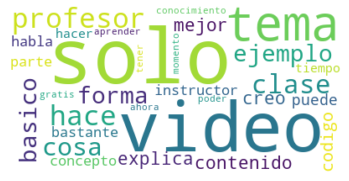

,Dominant_Topic,Text,Text_Cleaned
1554,7_nada,"empezando por que no se llama como el curso en el que yo me matriculé, y eso no crea confianza. Yo me matriculé de Teledetección, y a pesar de que el temario pueda ser compartido o incluso igual, estoy haciendo un curso que no se llama así. Los últimos 10 ó 12 módulos que he visto son todos iguales, duran 2 minutos y tras repetir lo mismo al inicio y al final, te queda 1 minuto de video, cuya metodología se repite. Las combinaciones de bandas y la interpretación se puede exponer de una manera mucho más aprovechable para el alumno.","[empezando, llama, matricule, crea, confianza, matricule, teledeteccion, pesar, temario, pueda, compartido, incluso, igual, haciendo, llama, ultimos, modulos, visto, iguales, duran, minutos, tras, repetir, mismo, inicio, final, queda, minuto, video, cuya, metodologia, repite, combinaciones, bandas, interpretacion, puede, exponer, manera, aprovechable, alumn]"
4128,7_nada,"Las explicaciones son muy claras, sin embargo, creo que el alcance de lo que se puede hacer con la información es muy limitado. Ejemplo: únicamente mercancías livianas, con proveedores que manejen DDP y sólo mediante transporte aéreo. Ya mejor díganme que sólo puedo importar funkos.","[explicaciones, claras, embargo, creo, alcance, puede, hacer, informacion, limitado, ejemplo, unicamente, mercancias, livianas, proveedores, manejen, solo, mediante, transporte, aereo, mejor, diganme, solo, puedo, importar, funk]"
12566,7_nada,"al ingresar al primer modulo, se nos indica leer un artículo en una página web de un periódico de Colombia, pues el vínculo no existe y te lleva a la misma página, ofreciendo otro tipo de información del día y no sobre el artículo donde informa la creación de la emisora de radio","[ingresar, primer, modulo, indica, leer, articulo, pagina, periodico, colombia, pues, vinculo, existe, lleva, misma, pagina, ofreciendo, tipo, informacion, articulo, informa, creacion, emisora, radi]"


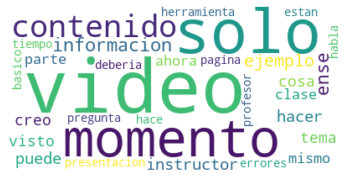

,Dominant_Topic,Text,Text_Cleaned
13429,8_comentario_incomprensible,"So far it's been a very enjoyable course, I like it.\n\nI understand that this introductory course consists of a summary which in turn consists of some videos of the other courses of the same author. \n\nHowever, it is a bit annoying that it alludes to videos that are not part of this one, particularly when it talks about the video about sharpening formones that is not included in this course. On the other hand, the final video of the finishes has nothing to do, the only justification I find for its inclusion in this course is because at the end promotes some more advanced work and courses.\n\nFor the rest, I reaffirm what I said at the beginning.","[been, very, enjoyable, like, understand, that, this, introductory, consists, summary, which, turn, consists, some, videos, other, same, author, however, annoying, that, alludes, videos, that, part, this, particularly, when, talks, about, video, about, sharpening, formones, that, included, this, other, hand, final, video, finishes, nothing, only, justification, find, inclusion, this, because, promotes, some, more, advanced, work, rest, reaffirm, what, said, beginning]"
9202,8_comentario_incomprensible,"I'd like to be honest with you my friend, I think you have the right idea but it isn't implemented in a good way, you don't need to repeat the words during the video, because it's monotonous, I think you could simulate situations of the real life and it'll be more interesting. Great project.","[like, honest, with, friend, think, have, right, idea, implemented, need, repeat, words, during, video, because, monotonous, think, could, simulate, situations, real, life, more, interesting, great, project]"
990,8_comentario_incomprensible,"Things to improve: \n-Some times (not many) the pronunciation of the words in Spanish is not correct and this could cause some confusion.\n-The practices appear before the explanation.\n-All assignments are the same, so it makes them a little boring. Try to vary the assignments.\n\nGood things:\n- The explanations are good\n- The material is good\n- Cases of study are great examples of how all this works and it also helps to understand that even though, Scrum@Scale defines some concepts and names to some roles, ceremonies and/or teams, it is also very flexible and can work with some little differences.\n-","[things, improve, some, times, many, pronunciation, words, spanish, correct, this, could, cause, some, confusion, practices, appear, before, explanation, assignments, same, makes, them, little, boring, vary, assignments, things, explanations, material, cases, study, great, examples, this, works, also, helps, understand, that, even, though, scrum, scale, defines, some, concepts, names, some, roles, ceremonies, teams, also, very, flexible, work, with, some, little, differenc]"


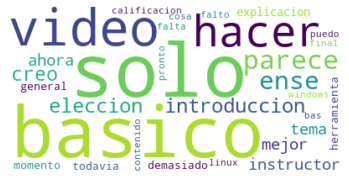

,Dominant_Topic,Text,Text_Cleaned
11029,9_poco_claro,"En primer lugar, me parece un curso útil, que traza algunas líneas del marketing online.\nSin embargo, considero que las explicaciones se quedan faltas de contenido, que los ejemplos en muchos casos son pobres y que algunas de las expresiones utilizadas no son fáciles de comprender.\nA pesar de todo, gracias por su curso.\nUn saludo.","[primer, lugar, parece, util, traza, lineas, marketing, online, embargo, considero, explicaciones, quedan, faltas, contenido, ejemplos, casos, pobres, expresiones, utilizadas, faciles, comprender, pesar, salud]"
2760,9_poco_claro,"Es muy desmotivante ver que el tutor hace varios meses no responde las inquietudes de sus alumnos, las explicaciones son demasiado cortas , y no explica bien como es el manejo de los futuros.\nEn lo referente al psicotrading deja mucho que desear.\n\nRealmente tenia una mejor expectativa del curso","[desmotivante, tutor, hace, varios, meses, responde, inquietudes, alumnos, explicaciones, demasiado, cortas, explica, manejo, futuros, referente, psicotrading, deja, desear, realmente, tenia, mejor, expect]"
12642,9_poco_claro,"La explicacion muchas veces es poco clara debido a la forma de expresarse del docente. \nAdemas habla demasiado rapido por ser un curso ""basico"" y se mueve demasiado rapidamente con el cursor dando ""por hecho"" muchos aspectos que no los son para un principiante","[explicacion, veces, clara, debido, forma, expresarse, docente, ademas, habla, demasiado, rapido, basico, mueve, demasiado, rapidamente, dando, hecho, aspectos, principi]"


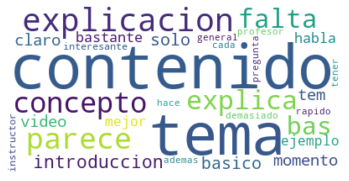

In [131]:
% matplotlib inline

topics = df_dominant_topic['Dominant_Topic'].unique()
topics.sort()

for topic in topics:
  print()
  print()
  df_dominant_filtered = df_dominant_topic[df_dominant_topic['Dominant_Topic']==topic].sort_values("Topic_Perc_Contrib",ascending=False)[["Dominant_Topic","Text","Text_Cleaned"]]
  display(df_dominant_filtered.head(3))
  # Import the wordcloud library
  from wordcloud import WordCloud
  # Join the different processed titles together.
  long_string = ','.join(list([' '.join(map(str, l)) for l in df_dominant_filtered['Text_Cleaned']]))
  # Create a WordCloud object
  wordcloud = WordCloud(background_color="white", max_words=30, contour_width=3, contour_color='steelblue')
  # Generate a word cloud
  wordcloud.generate(long_string)
  # Visualize the word cloud
  wordcloud.to_image()
  # Display the generated image:
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.show()


In [109]:
df_news['label'] = df_dominant_topic['Dominant_Topic']
df_news['label_id'] = df_dominant_topic['Dominant_Topic_number']
df_news['label_confidence'] = df_dominant_topic['Topic_Perc_Contrib']
df_news["label"].fillna("X",inplace=True)

Let's examine some text and its topics

In [110]:
df_news[['comment', 'label','label_id']].sample(10)

,comment,label,label_id
6819,"Interesante curso, sin embargo no da herramientas de como equilibrar la parte emocional y la parte lógica, solo menciona que los instintos nos pueden salvar a veces, pero para hacer una introspección y ver que necesitamos mejorar e identificar los pain points, es necesario tener herramientas o estrategias que me hubiera gustado escuchar.",2_faltan_explicaciones,1
2198,hablar un poco mas lento,6_dificil_de_seguir,5
13404,"Le escribí al tutor por este medio y no me respondió.\nTuve un problema con el ""server_install.bat"" porque me aparecía un error de que: ""...no ha podido iniciarse"".\nLe comuniqué al tutor y no me respondió. \nYa he intentado de todo y no he podido iniciar el curso aún porque no tengo el software instalado.\n\nUn curso debería contemplar todos esos riesgos para que los estudiantes puedan llevarlo a cabo exitosamente. \nLastimosamente, quedo decepcionado.",1_muy_introductorio,0
10628,"El audio es muy malo, y el manual que está en en pdf o se descarga dice qué hay un error en el link",1_muy_introductorio,0
3034,"Un desastre, muy desordenado. Cuesta mucho seguirlo. \nUn error haberlo comprado.",5_video_y_audio,4
11198,"Esta bien, pero muchas veces hace cosas que no se explican y toca ingeniárselas para lograr quedar al mismo nivel que el proyecto, tampoco sintetiza el tema aprendido, Anda cortando muchos pedazos y hace que por mas agilidad que tengas typeando no lo alcances y te toca pausar el vídeo y revisar que estén bien las cosas.",3_poco_preciso,2
8445,"Muy mal curso, se llama Psicologia del Adolescente y dice que va dirigido a Psicologos, Orientadores educativos, Padres, y Estudiantes de psicología pero solo parece una guía moral de como ser buenos padres. No tiene nada que ver con psicología y el instructor parece más predicador cristiano que psicólogo. CERO RECOMENDABLE",3_poco_preciso,2
6443,"El curso es bueno y el profesor explica bien. Sin embargo yo tenia más expectativa sobre el curso; pensé que iban a enseñar más técnicas de la guitarra clásica y que yo iba a poder tocar esas obras que parecen que sonaran 3 guitarras al tiempo cuando en realidad es una guitarra. Además, casi no hay teoría musical.",5_video_y_audio,4
10641,"Lo encontré algo básico para todas las metodologías que tiene lean, pero cumple su función., auque siento que tal vez falto detallar mas como Crystal.",1_muy_introductorio,0
1584,"todo estaba bien, hasta que te dice que hay que usar una aplicacion la cual es cara (en dolares) y de ahi se va muy rapido la explicacion y pierdes interes.",8_comentario_incomprensible,7


In [111]:
for label_id in range(10):
    display(df_news[ df_news['label_id'] == label_id].sort_values(by='label_confidence',ascending=False)[['label_id','label','comment','comment_cleaned']].head(5))

,label_id,label,comment,comment_cleaned
601,0,1_muy_introductorio,"El curso es muy bueno, el profesor demuestra conocimiento pleno de los temas, sin embargo seria bueno que indique que archivo que se usará en cada clase principalmente al iniciar el curso y ser un poco mas ordenado.","[profesor, demuestra, conocimiento, pleno, temas, embargo, seria, indique, archivo, usara, cada, clase, principalmente, iniciar, orden]"
1551,0,1_muy_introductorio,"El curso cumple una función introductoria, lo cual no está mal, sin embargo considero que podría profundizar un poco más en algunos aspectos. Por otro lado, algunos de los datos para trabajar en arcmap tienen errores.","[cumple, funcion, introductoria, embargo, considero, podria, profundizar, aspectos, lado, datos, trabajar, arcmap, error]"
12205,0,1_muy_introductorio,Buen curso para iniciarse en el manejo de este framework sin embargo le falta el desarrollo de varios temas muy importantes co o la gestión de las sesiones de usuario entre otros.,"[iniciarse, manejo, framework, embargo, falta, desarrollo, varios, temas, importantes, gestion, sesiones, usuari]"
15264,0,1_muy_introductorio,"la informacion es bastante util,sin embargo, me gustaria se prefundisara un poco mas en ciertos aspectos. tener mas ejemplos de cada tema que se hable.","[informacion, bastante, util, embargo, gustaria, prefundisara, ciertos, aspectos, tener, ejemplos, cada, tema, h]"
18714,0,1_muy_introductorio,"Como introducción novel al tema está bien (explicaciones un 10), pero falta muuuucho contenido. No se entra en temas de reparaciones. Tenía las expectativas del curso más altas.","[introduccion, novel, tema, explicaciones, falta, muuuucho, contenido, entra, temas, reparaciones, tenia, expectativas, alt]"


,label_id,label,comment,comment_cleaned
11707,1,2_faltan_explicaciones,"Explica bien pero no hay ejemplos de proyectos reales donde aplicar lo que enseña , lo cual se queda bastante cojo el curso.\nSi explica el justify-content que haga un mini proyecto de como se aplica ese concepto en una pagina web real.\nluego la propiedad flex: 1 0 dice que se omite la propiedad flex-shrink cuando no es así , el valor por defecto de flex-shrink es 1 lo cual el elemento hijo se queda igual por eso no hay modificación en el ancho de ese elemento.","[explica, ejemplos, proyectos, reales, aplicar, ense, queda, bastante, cojo, explica, justify, content, haga, mini, proyecto, aplica, concepto, pagina, real, luego, propiedad, flex, dice, omite, propiedad, flex, shrink, valor, defecto, flex, shrink, elemento, hijo, queda, igual, modificacion, ancho, element]"
17397,1,2_faltan_explicaciones,"Muy buena explicación para iniciarse en el mundo de CSS, yo diría que la mejor forma de hacerlo, mas si se complementa con el curso de HTML del mismo Navis Code. Solo agregar que me hubiese gustado ver una sección para explicar brevemente que significa cada propiedad utilizada a lo largo del tutorial para que en la marcha se haga mas didáctico ver el avance con los proyectos 1 y 2. Lo demás excelente, nada que decir.","[explicacion, iniciarse, mundo, diria, mejor, forma, hacerlo, complementa, html, mismo, navis, code, solo, agregar, gustado, seccion, explicar, brevemente, significa, cada, propiedad, utilizada, largo, tutorial, marcha, haga, didactico, avance, proyectos, demas, dec]"
483,1,2_faltan_explicaciones,"Un desastre, aunque he sacado varias veces el 100% de las preguntas de pruebas, a la hora de la verdad ni se parecen a las del examen real. Como no se actualice este curso es poco útil para el examen actual. Cierto es que las preguntas de ejemplo que vienen con el programa oficial tampoco se parecen al examen actual. Hay algo que no se ha actualizado debidamente","[desastre, sacado, varias, veces, preguntas, pruebas, hora, verdad, parecen, examen, real, actualice, util, examen, actual, cierto, preguntas, ejemplo, vienen, programa, oficial, tampoco, parecen, examen, actual, actualizado, debid]"
18691,1,2_faltan_explicaciones,"Me sabe mal, pero esto es un curso para enseñar a un alumno y no para ver todo lo tu sabes, que es mucho. Primero, no me ha gustado que saques todos los errores en modo desarrollo. Luego, he encontrado algun corte de video, con alguna modificación de código, sin poder ver o saber el porque se ha hecho (ej. token en base de datos)\nSaludos","[sabe, ense, alumno, sabes, primero, gustado, saques, errores, modo, desarrollo, luego, encontrado, algun, corte, video, alguna, modificacion, codigo, poder, saber, hecho, token, base, datos, salud]"
10825,1,2_faltan_explicaciones,"Falta librerías (por ejemplo socket que se usa mucho para scripts); explicar qué significa cada objeto en inglés para que no se aprenda de memoria y se entienda qué significa (no sólo para qué sirve), por ejemplo len(gth).\nComo primera parte o introducción al lenguaje está bien, lejos de experto.","[falta, librerias, ejemplo, socket, scripts, explicar, significa, cada, objeto, ingles, aprenda, memoria, entienda, significa, solo, sirve, ejemplo, primera, parte, introduccion, lenguaje, lejos, expert]"


,label_id,label,comment,comment_cleaned
17152,2,3_poco_preciso,"Sí alguien va empezando por con la programación, al estar desactualizado el video con relación al Butterknife (que fue suplantado por ViewBinding) y al llegar al video del recurso en donde ""explica"" cómo tratar este cambio, es algo complicado. De igual forma, tiene otro video donde explica desde 0 cómo iniciar con Viewbinding, y creo que ese sería el video correcto al que debe redirigir","[alguien, empezando, programacion, desactualizado, video, relacion, butterknife, suplantado, viewbinding, llegar, video, explica, tratar, cambio, complicado, igual, forma, video, explica, iniciar, viewbinding, creo, seria, video, correcto, debe, redirig]"
18335,2,3_poco_preciso,"Realmente no ayudó en nada, el título le queda demasiado grande; el nombre que yo le pondría sería: ""Mi primera aplicación con Android (Primeros pasos)"". Mostrar Android N como novedad es demasiado para este curso ya que no explican la importancia de las API's y la elección de estás.","[realmente, ayudo, titulo, queda, demasiado, grande, nombre, pondria, seria, primera, aplicacion, android, primeros, pasos, mostrar, android, novedad, demasiado, explican, importancia, eleccion]"
2522,2,3_poco_preciso,"seria excelente una mejor explicacion, donde adquirir ciertos dispositivos, terminos o terminologia usada entre otros, uso de otros dispositivos y no exactamente el que el usa ya que no muchos tenemos acceso al dispositivo y no podemos poner en practica lo que se aprende.","[seria, mejor, explicacion, adquirir, ciertos, dispositivos, terminos, terminologia, usada, dispositivos, exactamente, acceso, dispositivo, podemos, poner, practica, aprend]"
13881,2,3_poco_preciso,"Cumplió con mis expectativas de aprender los fundamentos básicos, pero al intentar realizar la practica; en el último caso no lo logré debido a no entender la instalación de los programas necesarios.","[cumplio, expectativas, aprender, fundamentos, basicos, intentar, realizar, practica, ultimo, caso, logre, debido, entender, instalacion, programas, necesari]"
12956,2,3_poco_preciso,"Hasta el momento no ha llenado mis expectativas, me parece algo aburrido el curso, no he aprendido nada nuevo, y esperaba aprender nuevos métodos o tips para desarrollarme mejor en mi ambiente de trabajo sin embargo parece un curso de autosuperación personal.","[momento, llenado, expectativas, parece, aburrido, aprendido, nuevo, esperaba, aprender, nuevos, metodos, tips, desarrollarme, mejor, trabajo, embargo, parece, autosuperacion, personal]"


,label_id,label,comment,comment_cleaned
804,3,4_falta_práctica,"Siento que el curso está bastante desactualizado en lo que respecta a las herramientas que se utilizan para el hacking, ya que algunas están obsoletas o ya cambiaron sus términos de licencia y no se pueden explotar al 100%.\n\nAún así en lo que respecta a teoría si aclara bastante el panorama de cómo trabajan los hackers o cómo le hacen para llevar a cabo su ""trabajo"".","[siento, bastante, desactualizado, respecta, herramientas, utilizan, hacking, estan, obsoletas, cambiaron, terminos, licencia, pueden, explotar, respecta, teoria, aclara, bastante, panorama, trabajan, hackers, hacen, llevar, cabo, trabaj]"
13063,3,4_falta_práctica,"Entre la oferta de cursos gratis me llamó la atención este curso, en un principio pensé que sería un curso para mejorar mi carrera profesional pero se trata de un curso que te educa para desarrollar tu actividad laboral cuidando tu salud.\n\nLo recomiendo aunque se me ha hecho un poco pesado, creo que es un cursillo muy útil si nos valoramos lo más minimo.\n\nPablo","[oferta, gratis, llamo, atencion, principio, pense, seria, mejorar, carrera, profesional, trata, educa, desarrollar, actividad, laboral, cuidando, salud, recomiendo, hecho, pesado, creo, cursillo, util, valoramos, minimo, pabl]"
3166,3,4_falta_práctica,Hasta que llego al punto de los test perfecto. Buena refactorización y trucos. La explicación de como implementar los test nula. No entiendo nada en el primer test del endpoint Get. Da por hecho que sabemos lo que hay que hacer con JEST pero no tengo ni idea de lo que está explicando. \n\nGracias de todas formas,"[llego, punto, test, perfecto, buena, refactorizacion, trucos, explicacion, implementar, test, nula, entiendo, primer, test, endpoint, hecho, sabemos, hacer, jest, idea, explicando, todas, form]"
5903,3,4_falta_práctica,"Esperaba un poco más del curso, no se aprende nada en detalle, solamente es un repaso de cada componente de la documentación y luego una aplicación muy básica donde no se explica de forma técnica cada cosa que se hace.","[esperaba, aprende, detalle, solamente, repaso, cada, componente, documentacion, luego, aplicacion, basica, explica, forma, tecnica, cada, cosa, hac]"
12052,3,4_falta_práctica,"Está bien como explica la base del Mindfullness, pero es bastante insuficiente a la hora de explicar como lograr hábitos saludables que una persona pretenda en su vida. Las técnicas que comenta son para aplicar Mindfullness, pero no para incorporar e implementar nuevos hábitos en la persona.","[explica, base, mindfullness, bastante, insuficiente, hora, explicar, lograr, habitos, saludables, persona, pretenda, vida, tecnicas, comenta, aplicar, mindfullness, incorporar, implementar, nuevos, habitos, person]"


,label_id,label,comment,comment_cleaned
7271,4,5_video_y_audio,"Falta mas seriedad del instructor, dice mucho "" eh, eh, eh, perdon, eh, eh, perdon."" no es seguro de si mismo, demuestra duda y falta de conocimiento. y ademas la fuente de información es de wikipedia, son fuente dudosa, que cualquiera puede editar y agregar cualquier cosa. debe ser fuente confiable. wikipedia no puede ser fuente de información para un curso que dice ser serio.","[falta, seriedad, instructor, dice, perdon, perdon, seguro, mismo, demuestra, duda, falta, conocimiento, ademas, fuente, informacion, wikipedia, fuente, dudosa, cualquiera, puede, editar, agregar, cualquier, cosa, debe, fuente, confiable, wikipedia, puede, fuente, informacion, dice, seri]"
4503,4,5_video_y_audio,"Este curso estaría mejor si se hubiera sido subtitulado (como las peliculas) el instructor a pesar sus buenas intenciones, se pierde al dar explicaciones y creo que hace más largos los videos de lo que en realidad deberían de ser, se ve que no tenia un guión preparado, esto deriva en que el instructor tiene una ""muletilla"" deseperante que esta en la mayoría de las lecciones que vi, es un ""ehh, ehh, ehh"" como si pensara que decir.\nAdemás juro que escuche ladrar perros y personas hablaban en el fondo. En fin.","[estaria, mejor, sido, subtitulado, peliculas, instructor, pesar, intenciones, pierde, explicaciones, creo, hace, largos, videos, realidad, deberian, tenia, guion, preparado, deriva, instructor, muletilla, deseperante, mayoria, lecciones, pensara, decir, ademas, juro, escuche, ladrar, perros, personas, hablaban, fond]"
18866,4,5_video_y_audio,"Definitivamente esto es una recopilación de videos de YouTube, no estoy seguro si Udemy es la plataforma ideal, aquí se viene a tomar cursos y a aprender no a ver publicidad de Solange Candelo y su empresa Realtaria, tiene poca información útil como curso pero las partes en las que los agentes inmobiliarios hablan de por qué Realtaria es una buena empresa no me interesa en lo absoluto, deberian quitarlo, en fin, no me puedo quejar ya que la poca información pues es gratis.","[definitivamente, recopilacion, videos, youtube, seguro, udemy, plataforma, ideal, aqui, viene, tomar, aprender, publicidad, solange, candelo, empresa, realtaria, poca, informacion, util, partes, agentes, inmobiliarios, hablan, realtaria, empresa, interesa, absoluto, deberian, quitarlo, puedo, quejar, poca, informacion, pues, gratis]"
18818,4,5_video_y_audio,"Lo bueno, si es gratis mejor. El problema es que este curso es más como regular, pero lo gratis lo hace atractivo. Es básicamente el tutorial de NestJS narrado en un español en donde el inglés brilla totalmente por su ausencia, para bien o para mal. La verdad, nada que seguir la documentación no te pueda dar.\n\nLa explicación de Postman es un plus para las personas que no saben nada de la herramienta.","[gratis, mejor, problema, regular, gratis, hace, atractivo, basicamente, tutorial, nestjs, narrado, espa, ingles, brilla, totalmente, ausencia, verdad, seguir, documentacion, pueda, explicacion, postman, plus, personas, saben, herramient]"
10910,4,5_video_y_audio,"Se recomienda hacer una mejor planeación de las clases para dar dar una enseñanza más efectiva, mejorar tono de la voz ya que tiende a ser monótono y puede aburrir a los estudiantes, por otra parte manejar mejor la modulación de la voz con el micrófono para lograr un mejor audio","[recomienda, hacer, mejor, planeacion, clases, ense, anza, efectiva, mejorar, tono, tiende, monotono, puede, aburrir, estudiantes, parte, manejar, mejor, modulacion, microfono, lograr, mejor, audi]"


,label_id,label,comment,comment_cleaned
12421,5,6_dificil_de_seguir,"Primero de todo el titulo es un poco engañoso. Que el curso se llame master en machine learning que es lo que me interesaba y realmente no se vea nada de machine learning ha sido un poco decepcionante. Al principio era en plan veremos como limpiar datos, veremos como aplicarlo a machine learning, etc y por ello me quede hasta el final (aunque por el temario de curso no me diese esa impresión, pero bueno dije al principio hará un repaso de los lenguajes y se irá acercando más como decía al principio).\nEl segundo punto es que encuentro que el curso no está conexo. Es decir que veo que al final se ha ordenado de otra forma. Da la impresión que por los comentarios, primero tuviese que ir todo lo de R y luego todo lo de Python. Además a veces oías algo del estilo ""como vimos al final de la unidad anterior"" cuando a lo mejor hace dos temas que lo vimos o por ejemplo en la unidad 65 (La estadística, la base para\ncualquier analista de datos) es como si fuese sacado de otro curso porque al iniciar el video en el video se aprecian cosas tipo summary(data$mpg) o str(data$cylinders) que no lo hemos visto y empieza diciendo ""como acabamos de ver"". Dices bueno esto no tendrá importancia, lo que requiere es lo que vendrá a continuación. Pero ves que no, que como datos usa data$mpg que no sabemos ni como se obtiene, si mediante paquete o ese data y ese mpg viene de alguna instrucción o de donde. \nEl tercer punto y algo más positivo, es que a pesar de esto, me pareció que supo explicar muy bien tanto en el video como en el material proporcionado y poner unos ejemplos sencillos y claros. Es por esta parte que añadí la media estrella más, pero si no iba de cabeza a la estrella por todo lo comentado al principio que sinceramente me ha decepcionado mucho","[primero, titulo, enga, llame, master, machine, learning, interesaba, realmente, machine, learning, sido, decepcionante, principio, plan, veremos, limpiar, datos, veremos, aplicarlo, machine, learning, ello, quede, final, temario, diese, impresion, dije, principio, hara, repaso, lenguajes, acercando, decia, principio, segundo, punto, encuentro, conexo, decir, final, ordenado, forma, impresion, comentarios, primero, luego, python, ademas, veces, oias, estilo, vimos, final, unidad, anterior, mejor, hace, temas, vimos, ejemplo, unidad, estadistica, base, paracualquier, analista, datos, sacado, iniciar, video, video, aprecian, cosas, tipo, summary, data, data, cylinders, visto, empieza, diciendo, acabamos, dices, tendra, importancia, requiere, vendra, continuacion, datos, data, sabemos, obtiene, mediante, paquete, data, viene, alguna, instruccion, tercer, ...]"
509,5,6_dificil_de_seguir,"Comparada con los cursos de Logali, este da la impresión de estar menos preparado, trata de explicar los temas pero tiene que ir resolviendo incidentes conforme se desarrolla el curso. Es bueno, pero muy corto; para la amplia gama de cosas nuevas del abap 7.4 esta muy limitado. Además, insisto, si se tiene la referencia de los cursos de Logali, a este le falta mas forma y estructura. Revisen el curso de POO ABAP de Logali, diapositivas animadas, curso preparado de inicio a fin, ejemplos claro, precisos y sin error. La verdad, estoy muy decepcionado de lo que pague.","[comparada, logali, impresion, menos, preparado, trata, explicar, temas, resolviendo, incidentes, conforme, desarrolla, corto, amplia, gama, cosas, nuevas, abap, limitado, ademas, insisto, referencia, logali, falta, forma, estructura, revisen, abap, logali, diapositivas, animadas, preparado, inicio, ejemplos, claro, precisos, error, verdad, decepcionado, pag]"
2809,5,6_dificil_de_seguir,"Quiero agradecer por tan valiosa información, en mi caso el Estudio del idioma Ingles no se meda de forma natural y fácil, pero ahora que escucho la profesora ANNA me trasmitió tanta pasión y positivismo que estoy deseosa de iniciar y poder llegar al final con muy buenos resultados.\nGracias pro

,label_id,label,comment,comment_cleaned
1554,6,7_nada,"empezando por que no se llama como el curso en el que yo me matriculé, y eso no crea confianza. Yo me matriculé de Teledetección, y a pesar de que el temario pueda ser compartido o incluso igual, estoy haciendo un curso que no se llama así. Los últimos 10 ó 12 módulos que he visto son todos iguales, duran 2 minutos y tras repetir lo mismo al inicio y al final, te queda 1 minuto de video, cuya metodología se repite. Las combinaciones de bandas y la interpretación se puede exponer de una manera mucho más aprovechable para el alumno.","[empezando, llama, matricule, crea, confianza, matricule, teledeteccion, pesar, temario, pueda, compartido, incluso, igual, haciendo, llama, ultimos, modulos, visto, iguales, duran, minutos, tras, repetir, mismo, inicio, final, queda, minuto, video, cuya, metodologia, repite, combinaciones, bandas, interpretacion, puede, exponer, manera, aprovechable, alumn]"
4128,6,7_nada,"Las explicaciones son muy claras, sin embargo, creo que el alcance de lo que se puede hacer con la información es muy limitado. Ejemplo: únicamente mercancías livianas, con proveedores que manejen DDP y sólo mediante transporte aéreo. Ya mejor díganme que sólo puedo importar funkos.","[explicaciones, claras, embargo, creo, alcance, puede, hacer, informacion, limitado, ejemplo, unicamente, mercancias, livianas, proveedores, manejen, solo, mediante, transporte, aereo, mejor, diganme, solo, puedo, importar, funk]"
12566,6,7_nada,"al ingresar al primer modulo, se nos indica leer un artículo en una página web de un periódico de Colombia, pues el vínculo no existe y te lleva a la misma página, ofreciendo otro tipo de información del día y no sobre el artículo donde informa la creación de la emisora de radio","[ingresar, primer, modulo, indica, leer, articulo, pagina, periodico, colombia, pues, vinculo, existe, lleva, misma, pagina, ofreciendo, tipo, informacion, articulo, informa, creacion, emisora, radi]"
6242,6,7_nada,"Los vídeos se trababan y no se entendía lo que decía en partes, se debería compartir la presentación en powerpoint con las notas. Además tenía faltas de ortografía tanto en español como en inglés.","[videos, trababan, entendia, decia, partes, deberia, compartir, presentacion, powerpoint, notas, ademas, tenia, faltas, ortografia, espa, ingl]"
59,6,7_nada,"La verdad en el tema 5 minuto 14 aproximadamente esta mal editado, incluso la facilitadora dice una mala palabra debieron haber editado bien este video. Por favor tomen esto como algo constructivo. Gracias","[verdad, tema, minuto, aproximadamente, editado, incluso, facilitadora, dice, mala, palabra, debieron, haber, editado, video, favor, tomen, construct]"


,label_id,label,comment,comment_cleaned
13429,7,8_comentario_incomprensible,"So far it's been a very enjoyable course, I like it.\n\nI understand that this introductory course consists of a summary which in turn consists of some videos of the other courses of the same author. \n\nHowever, it is a bit annoying that it alludes to videos that are not part of this one, particularly when it talks about the video about sharpening formones that is not included in this course. On the other hand, the final video of the finishes has nothing to do, the only justification I find for its inclusion in this course is because at the end promotes some more advanced work and courses.\n\nFor the rest, I reaffirm what I said at the beginning.","[been, very, enjoyable, like, understand, that, this, introductory, consists, summary, which, turn, consists, some, videos, other, same, author, however, annoying, that, alludes, videos, that, part, this, particularly, when, talks, about, video, about, sharpening, formones, that, included, this, other, hand, final, video, finishes, nothing, only, justification, find, inclusion, this, because, promotes, some, more, advanced, work, rest, reaffirm, what, said, beginning]"
9202,7,8_comentario_incomprensible,"I'd like to be honest with you my friend, I think you have the right idea but it isn't implemented in a good way, you don't need to repeat the words during the video, because it's monotonous, I think you could simulate situations of the real life and it'll be more interesting. Great project.","[like, honest, with, friend, think, have, right, idea, implemented, need, repeat, words, during, video, because, monotonous, think, could, simulate, situations, real, life, more, interesting, great, project]"
990,7,8_comentario_incomprensible,"Things to improve: \n-Some times (not many) the pronunciation of the words in Spanish is not correct and this could cause some confusion.\n-The practices appear before the explanation.\n-All assignments are the same, so it makes them a little boring. Try to vary the assignments.\n\nGood things:\n- The explanations are good\n- The material is good\n- Cases of study are great examples of how all this works and it also helps to understand that even though, Scrum@Scale defines some concepts and names to some roles, ceremonies and/or teams, it is also very flexible and can work with some little differences.\n-","[things, improve, some, times, many, pronunciation, words, spanish, correct, this, could, cause, some, confusion, practices, appear, before, explanation, assignments, same, makes, them, little, boring, vary, assignments, things, explanations, material, cases, study, great, examples, this, works, also, helps, understand, that, even, though, scrum, scale, defines, some, concepts, names, some, roles, ceremonies, teams, also, very, flexible, work, with, some, little, differenc]"
6513,7,8_comentario_incomprensible,"I think that He was more focus in Linux that docker, even though Linux is important, I hope a bit more regarding docker. more practices case!, thank u","[think, that, more, focus, linux, that, docker, even, though, linux, important, hope, more, regarding, docker, more, practices, case, thank]"
1965,7,8_comentario_incomprensible,"He talks a lot about his company and has very little content, you can see that the teacher knows a lot but does not know how to teach, which is what we come to, buy the course and everything is on YouTube, free.","[talks, about, company, very, little, content, that, teacher, knows, does, know, teach, which, what, come, everything, youtube, fre]"


,label_id,label,comment,comment_cleaned
11029,8,9_poco_claro,"En primer lugar, me parece un curso útil, que traza algunas líneas del marketing online.\nSin embargo, considero que las explicaciones se quedan faltas de contenido, que los ejemplos en muchos casos son pobres y que algunas de las expresiones utilizadas no son fáciles de comprender.\nA pesar de todo, gracias por su curso.\nUn saludo.","[primer, lugar, parece, util, traza, lineas, marketing, online, embargo, considero, explicaciones, quedan, faltas, contenido, ejemplos, casos, pobres, expresiones, utilizadas, faciles, comprender, pesar, salud]"
2760,8,9_poco_claro,"Es muy desmotivante ver que el tutor hace varios meses no responde las inquietudes de sus alumnos, las explicaciones son demasiado cortas , y no explica bien como es el manejo de los futuros.\nEn lo referente al psicotrading deja mucho que desear.\n\nRealmente tenia una mejor expectativa del curso","[desmotivante, tutor, hace, varios, meses, responde, inquietudes, alumnos, explicaciones, demasiado, cortas, explica, manejo, futuros, referente, psicotrading, deja, desear, realmente, tenia, mejor, expect]"
12642,8,9_poco_claro,"La explicacion muchas veces es poco clara debido a la forma de expresarse del docente. \nAdemas habla demasiado rapido por ser un curso ""basico"" y se mueve demasiado rapidamente con el cursor dando ""por hecho"" muchos aspectos que no los son para un principiante","[explicacion, veces, clara, debido, forma, expresarse, docente, ademas, habla, demasiado, rapido, basico, mueve, demasiado, rapidamente, dando, hecho, aspectos, principi]"
988,8,9_poco_claro,"El contenido es claro e interesante, ya he tomado un par de cursos con Fabian y me han sido de mucha utilidad. Encontré deficiencias en el material de apoyo y la sección 22. El lanzamiento no fue muy clara, pero en general se adquiere un gran conocimiento de scrum scale","[contenido, claro, interesante, tomado, fabian, sido, mucha, utilidad, encontre, deficiencias, material, apoyo, seccion, lanzamiento, clara, general, adquiere, gran, conocimiento, scrum, scal]"
598,8,9_poco_claro,"Si es bueno, pero estaría bien profundizar un poco en el cómo se hace. Todos los tips de automatizar respuestas, etc... algo así por el estilo. Hace falta más ilustraciones , videos explicativos, ejemplo en concreto, casos de éxito.","[estaria, profundizar, hace, tips, automatizar, respuestas, estilo, hace, falta, ilustraciones, videos, explicativos, ejemplo, concreto, casos, exit]"


,label_id,label,comment,comment_cleaned
11786,9,10_muy_superficial,"El curso está bien para iniciarse en Unity y echarle una tarde viendo funcionalidades básicas... Pero está incompleto, no haces más que diseñar un nivel, una moneda y para casa. Si quieres hacer el juego final tienes que hacer otro curso de pago. Como digo, un poco inutil hacer este curso, pero si nunca has tocado Unity sacas una idea muy superficial de como funciona.","[iniciarse, unity, echarle, tarde, viendo, funcionalidades, basicas, incompleto, haces, dise, nivel, moneda, casa, quieres, hacer, juego, final, hacer, pago, digo, inutil, hacer, nunca, tocado, unity, sacas, idea, superficial, funcion]"
3294,9,10_muy_superficial,"Es un buen curso para empezar, aprendes varias cosas pero no es un curso completo sobre ASP.NET MVC. Aunque explica varios temas importantes la verdad es que se dedica mucho a crear proyectos y explicar que fue lo que creo el Framework. Lo recomiendo si eres una persona que se esta iniciando en el desarrollo web pero si no es el caso no creo que vallas a aprender nada nuevo.","[empezar, aprendes, varias, cosas, completo, explica, varios, temas, importantes, verdad, dedica, crear, proyectos, explicar, creo, framework, recomiendo, persona, iniciando, desarrollo, caso, creo, vallas, aprender, nuev]"
11806,9,10_muy_superficial,El curso se titula: mi primer juego con unity 5. Pensé que se iba a realizar el juego completo y no solo el diseño. De todas formas me gustó ver este curso gratuito pues es la primera vez que toco Unity y me ayudó mucho a la hora de interactuar con la herramienta.,"[titula, primer, juego, unity, pense, realizar, juego, completo, solo, dise, todas, formas, gusto, gratuito, pues, primera, toco, unity, ayudo, hora, interactuar, herramient]"
2315,9,10_muy_superficial,hay mucha gente que no nos interesa descargar imágenes y creo que el instructor pierde mucho tiempo en cosas que no los que tenemos la idea de pagar un curso lo que queremos es aprender el programa y no aprender a bajar imágenes o estar en comunidades de facebook en fina gracias pero no me gusto,"[mucha, gente, interesa, descargar, imagenes, creo, instructor, pierde, tiempo, cosas, idea, pagar, queremos, aprender, programa, aprender, bajar, imagenes, comunidades, facebook, fina, gust]"
18566,9,10_muy_superficial,"Ah sido un curso muy bueno, aprendí buenas practicas las cuales me ayudaran mucho en mis proyectos, me gustaría que el curso fuese más extenso, pero vamos no puedo pedir mucho de un curso gratuito, mas sin embargo a sido un excelente curso.\nEl instructor es muy claro y se nota que posee conocimientos avanzados en sql","[sido, aprendi, practicas, cuales, ayudaran, proyectos, gustaria, extenso, vamos, puedo, pedir, gratuito, embargo, sido, instructor, claro, nota, posee, conocimientos, avanz]"


### let's see the distribution of topics


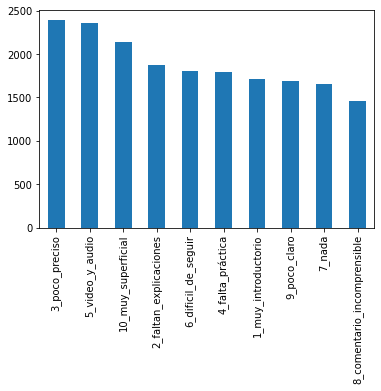

In [112]:
ax = df_dominant_topic['Dominant_Topic'].value_counts().plot(kind='bar')
plt.show()

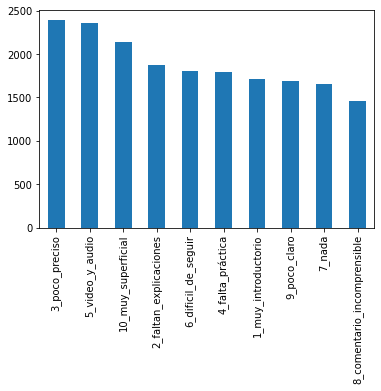

In [114]:
ax = df_news['label'].value_counts().plot(kind='bar')
plt.show()

The topis are almost balanced, so we are good

finally that we have our models set up, as well as analyzed, we can go
ahead to visualizing them.

In [115]:
import pyLDAvis

pyLDAvis.enable_notebook()

In [116]:
# %%time
import pyLDAvis.gensim
pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)

PreparedData(topic_coordinates=          x     y  topics  cluster  Freq
topic                                   
5      0.07  0.01       1        1 12.76
2     -0.04  0.02       2        1 12.52
1      0.00  0.02       3        1 11.93
4      0.12  0.09       4        1 11.53
9      0.05  0.03       5        1 11.26
6      0.14  0.03       6        1  9.87
3     -0.07  0.00       7        1  8.94
8     -0.03  0.02       8        1  7.64
0     -0.24  0.07       9        1  7.18
7     -0.00 -0.28      10        1  6.37, topic_info=            Term     Freq    Total Category  logprob  loglift
139        cosas 1,255.00 1,255.00  Default    30.00    30.00
552        audio   505.00   505.00  Default    29.00    29.00
78        videos 1,281.00 1,281.00  Default    28.00    28.00
16      explicar   797.00   797.00  Default    27.00    27.00
599    conceptos   819.00   819.00  Default    26.00    26.00
..           ...      ...      ...      ...      ...      ...
142  explicacion    58.08   921.69  Topic10    -5.25    -0.01
78        videos    58.33 1,281.04  Topic10    -5.24    -0.34
23          tema    51.72   856.94  Topic10    -5.36    -0.05
210        poder    48.57   475.57  Topic10    -5.43     0.47
150        video    48.15 1,027.06  Topic10    -5.43    -0.31

[799 rows x 6 columns], token_table=      Topic  Freq     Term
term                      
3463      9  0.95  abordan
3132     10  0.98    about
535       1  0.05    aburr
535       8  0.75    aburr
535      10  0.21    aburr
...     ...   ...      ...
151       4  0.08  youtube
151       5  0.23  youtube
151       6  0.35  youtube
151       8  0.01  youtube
151      10  0.01  youtube

[2068 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 3, 2, 5, 10, 7, 4, 9, 1, 8])

In [117]:
len(df_news),df_news.isna().sum()

(18883, index               0
 id                  0
 course              0
 rating              0
 comment             0
 user                1
 tag                 0
 comment_cleaned     0
 label               0
 label_id            0
 label_confidence    0
 dtype: int64)

In [118]:
# NOW.... GROUP BY COURSE
# AND GROUP BY LABEL THEN

In [119]:
df_by_course = df_news.groupby("course")
df_agg_by_course = pd.DataFrame(index=df_news["course"].unique())

In [120]:
df_agg_by_course["comments"] = df_by_course['comment_cleaned'].agg(sum)
df_agg_by_course.sample(10)

,comments
3224079,"[ahora, considero, viendo, vide, iniciando, todavia, practico, solo, dando, idea, general, hace, falta, llevar, cabo, acciones, asimilando, realmente, informacion, creo, avanzando, familiarizando, plataforma, estructurando, gradualmente, funcion, videos, reproducen, baj, temas, esperaba, parecio, interesante, aclaro, varias, dudas, tenia, sugerencia, instructor, quizas, deberia, trabajar, pronunciacion]"
2857438,"[ahora, explica, superficialmente, tem]"
1229000,"[tener, idea, general, access, obstante, persona, conocimientos, medios, queda, corto, hora, enfrentarse, problema, real, surgen, muchisimas, dudas, cuanto, hora, realizar, consultas, formularios, ejemplo, manera, controlar, usuario, pueda, introducir, caracteres, diversos, campo, valor, cierto, tipo, macr, paso, pas, flojo, perooo, pagado, prisa, aprender, programa, aprovechar, inversion, recomiendo, vayas, haciendo, pauses, video, vaya, mismo, construyendo, bases, datos, usan, suficiente, partir, aula, basura, total, solo, teorico, practicas, probar, aprendes, sinceramente, recomiendo, puede, tener, idea, basica, programa, primeras, cl, eleccion, correcta, aqui, relator, quiero, avanzar, despues, opin, personal, sabia, access, inicio, paso, paso, creando, base, datos, creo, final, pudo, hacer, practico, principio, didactico, mejorar, ...]"
253082,"[temas, orden, especifico, temas, requieren, conocimientos, previos, casos, explicacion, rap]"
2405464,"[pues, explicacion, quedo, atras, conceptos, basicos, consola, base, comandos, facil, familiarizarse, entorno, grafico, forma, explic, altos, bajos, podria, mejorar, compartiera, codigos, hacer, facil, lectura, avance, vide, explica, claramente, instructor, opinion, seria, conocer, comandos, consola, principi, explicaciones, exelentes, embargo, alguna, falta, conocimientos, notable, explicado, despues, sali, usando, campeon, verdad, perdida, tiempo, hicieron, bajar, cosola, totalmente, pedo, nunca, ense, comando, sino, ense, usar, programa, pago, kraken, lament, creo, dedicaron, tiempo, markdown, faltaron, conceptos, pull, request, podria, mejor, valorar, trabajo, detras, instructores, solo, falta, manejo, consola, gitkraken, framework, evita, usar, comandos, sol, eleccion, puede, mejorar, zoom, videos, ampliar, conceptos, ejemplo, usar, gitflow, consola, ...]"
3759894,"[gustado, dise, aplicados, clientes, explicacion, amplia, materiales, mejores, condiciones, entorno, trabaj]"
3282188,"[segundo, video, introduccion, parece, calificacion, podria, dejar, espacio, pract, eleccion, pienso, podria, grano, menos, visto, primeros, vide, entiendo, prof]"
1826522,"[solo, sigue, tutorial, pagina, oficial, raills, agradable, sonido, teclas, mientras, expl]"
3437802,"[bastante, basico, partes, habla, elementos, narracion, cosas, basicas, escribir, explica, podria, haberse, aplicado, tipo, narraciones, solo, infantiles, creo, falta, especif]"
3699214,"[explica, debe, partir, embargo, muestra, ejemplos, pongan, aprueba, conocimiento, contar, partes, demasiado, rapido, recomiendo, solo, iniciando, intermedio, mejor]"


In [121]:
df_agg_by_course["labels_list"] = df_by_course['label'].apply(list)
df_agg_by_course.sample(10)

,comments,labels_list
2211750,"[principio, deja, claro, cosas, posteriormente, buscar, cuenta, saber, hac, claro, explicando, momento, principiantes, entonces, fallo, microfono, cal, principiante, programacion, encontre, errores, verdad, gusto, forma, ens, nuevo, tratando, entender, necesit, rapido, momento, explic, referencias, viejas, buscar, existen, cambiaron, puede, crear, confusion, menos, gratuito, mismo, pago, estaria, pidiendo, devolucion, mismo, menos, podria, editar, videos, vean, errores, principi, regresa, propias, palabras, conceptos, basicos, brindando, expresa, confianza, trasmite, habla, informal, entiende, hablar, rap, profesor, explica, enreda, mismo, veces, sabe, decir, sale, ocmo, esper, claro, instructor, empezar, nivel, basico, creo, explica, rapido, manera, superficial, decepcionante, instructor, mismo, confunde, idea, cuales, seran, resultados, hace, codig, interactivo, ...]","[10_muy_superficial, 6_dificil_de_seguir, 2_faltan_explicaciones, 2_faltan_explicaciones, 10_muy_superficial, 7_nada, 9_poco_claro, 9_poco_claro, 8_comentario_incomprensible, 2_faltan_explicaciones, 9_poco_claro, 10_muy_superficial, 6_dificil_de_seguir, 5_video_y_audio, 2_faltan_explicaciones, 2_faltan_explicaciones, 10_muy_superficial, 7_nada, 2_faltan_explicaciones, 10_muy_superficial, 8_comentario_incomprensible, 9_poco_claro, 6_dificil_de_seguir, 7_nada, 8_comentario_incomprensible, 10_muy_superficial, 10_muy_superficial, 2_faltan_explicaciones, 8_comentario_incomprensible, 10_muy_superficial, 4_falta_práctica, 8_comentario_incomprensible, 4_falta_práctica, 5_video_y_audio, 6_dificil_de_seguir, 2_faltan_explicaciones, 6_dificil_de_seguir, 6_dificil_de_seguir, 10_muy_superficial, 1_muy_introductorio, 7_nada, 4_falta_práctica, 2_faltan_explicaciones, 9_poco_claro, 10_muy_superficial, 5_video_y_audio, 6_dificil_de_seguir, 3_poco_preciso, 6_dificil_de_seguir, 10_muy_superficial, 6_dificil_de_seguir]"
1146754,"[segun, indicaba, descripcion, deberia, valer, cualquier, version, maya, empezar, indica, mentalray, maya, disponible, sirv]",[7_nada]
3604534,"[animos, ofender, ense, basico, google, pense, ibas, ense, hacks, secretos, tener, ventas, ense, relevancia, dejas, temas, aire, podria, encontrar, youtube, tiempo, minutos, creeme, falta, ense, ejemplo, remarketing, publicos, personalizados, campa, display, aparte, display, inteligente, mejorar, nivel, calidad, resolver, recomendaciones, google, vale, vale, falta, ense, verdad, decepcionado, cumple, expect, totalmente, decepcionante, adquiri, crei, aportar, valor, quede, totalmente, decepcionado, instructora, respeto, calidad, dama, sitio, udemy, quiero, decir, simplemente, adquieran, eviten, decepcion]","[2_faltan_explicaciones, 7_nada]"
2417894,"[quiten, musica, fondo, ponganla, bajenle, volumen, favor, hablan, constructivismo, abord, contenidos, explorados, videos, estan, explicados, gran, utilidad, practica, docente, mano, aparece, permanentemente, movimiento, rapido, tembloroso, genera, gran, distraccion, visual, dificulta, concentracion, bastante, regul]","[5_video_y_audio, 5_video_y_audio, 8_comentario_incomprensible, 10_muy_superficial]"
2228648,"[hecho, entendiendo, haciendo, referencias, desconocia, relaciones, actividad, cotidian]",[6_dificil_de_seguir]
3110202,"[promocion, pagos, verdad, solo, explica, encuentra, todas, part]",[7_nada]
2002066,"[experiencia, estupenda, pesar, solo, pongo, estrellas, terminar, practicante, puse, contacto, mail, recibido, todavia, diploma, academia, espero, primer, diploma, lleguen, pront]",[8_comentario_incomprensible]
2217574,"[curs, completo, basico, seria, agregara, siguiente, parte, complementari, bueno, familiarizarte, controles, siento, rapido, ejemplos, poder, captar, toda, informacion]","[6_dificil_de_seguir, 1_muy_introductorio]"
2146772,"[solo, inicio, puedo, valor, tutoriales, youtube, gratis, completos, siento, estafado, salgo, nunca, vuelvo, ingresar, plataforma, men, ense, propia, pagina, shopify, indique, momento, pasos, gu

In [122]:
df_agg_by_course['labels_len'] = df_agg_by_course['labels_list'].str.len()

In [123]:
df_agg_by_course.sort_values('labels_len', ascending=False).head(10)

,comments,labels_list,labels_len
1671664,"[cuenta, gratuito, cumple, objetivo, debe, recalcar, nombran, variables, tipos, forma, declararlas, adecuadamente, cualquier, modo, sirvio, aprendi, utilizar, adecuadamente, modulo, cl, siento, inconforme, indica, cero, entiendo, faltan, cosas, detalles, explicar, incompleto, youtube, buscar, mejor, darse, idea, funciona, comandos, explica, sirv, batallaba, muchisimo, entender, instructor, coincidia, cosas, decia, escribia, intentaba, interpretar, logre, recolectar, informacion, necesaria, cuestiones, conocia, realmente, basico, funciona, organizacion, temas, decepcionante, hora, entenderlo, aplicar, analiz, profesor, pronuncia, espa, cuesta, entend, estructura, deficiente, profesor, comunica, manera, flu, ense, basico, persona, confusa, explic, tono, explica, jerarquias, regul, explica, detalles, supone, principi, verdad, interes, iniciar, macros, excel, brev, buena, eleccion, perspectiva, modesta, abordaron, ...]","[2_faltan_explicaciones, 10_muy_superficial, 2_faltan_explicaciones, 10_muy_superficial, 5_video_y_audio, 2_faltan_explicaciones, 3_poco_preciso, 10_muy_superficial, 10_muy_superficial, 5_video_y_audio, 1_muy_introductorio, 1_muy_introductorio, 3_poco_preciso, 10_muy_superficial, 2_faltan_explicaciones, 3_poco_preciso, 4_falta_práctica, 8_comentario_incomprensible, 3_poco_preciso, 3_poco_preciso, 2_faltan_explicaciones, 9_poco_claro, 5_video_y_audio, 2_faltan_explicaciones, 1_muy_introductorio, 9_poco_claro, 2_faltan_explicaciones, 9_poco_claro, 6_dificil_de_seguir, 6_dificil_de_seguir, 5_video_y_audio, 5_video_y_audio, 4_falta_práctica, 10_muy_superficial, 9_poco_claro, 5_video_y_audio, 10_muy_superficial, 4_falta_práctica, 10_muy_superficial, 5_video_y_audio, 3_poco_preciso, 10_muy_superficial, 8_comentario_incomprensible, 6_dificil_de_seguir, 9_poco_claro, 2_faltan_explicaciones, 9_poco_claro, 10_muy_superficial, 10_muy_superficial, 5_video_y_audio, 5_video_y_audio, 4_falta_práctica, 4_falta_práctica, 2_faltan_explicaciones, 5_video_y_audio, 6_dificil_de_seguir, 5_video_y_audio, 5_video_y_audio, 6_dificil_de_seguir, 9_poco_claro, 6_dificil_de_seguir, 5_video_y_audio, 5_video_y_audio, 3_poco_preciso, 2_faltan_explicaciones, 3_poco_preciso, 7_nada, 6_dificil_de_seguir, 6_dificil_de_seguir, 5_video_y_audio, 2_faltan_explicaciones, 6_dificil_de_seguir, 7_nada, 2_faltan_explicaciones, 5_video_y_audio, 2_faltan_explicaciones, 5_video_y_audio, 10_muy_superficial, 2_faltan_explicaciones, 10_muy_superficial, 10_muy_superficial, 10_muy_superficial, 1_muy_introductorio, 10_muy_superficial, 5_video_y_audio, 4_falta_práctica, 3_poco_preciso, 2_faltan_explicaciones, 10_muy_superficial, 3_poco_preciso, 5_video_y_audio, 2_faltan_explicaciones, 3_poco_preciso, 8_comentario_incomprensible, 5_video_y_audio, 10_muy_superficial, 5_video_y_audio, 9_poco_claro, 3_poco_preciso, 9_poco_claro, ...]",152
1218500,"[califican, tareas, usuarios, quejan, certific, materiales, podrian, mejores, hace, dinam, corrigen, tareas, imposible, terminar, obtener, certificado, finalizacion, momento, requiere, trabajo, subtitulacion, bastan, subtitulos, automat, dificil, entender, instructor, dice, musica, hace, dificil, comprend, poca, claridad, id, formato, poner, imagenes, clases, presenciales, grabadas, agrega, valor, sido, mejor, tener, material, mejor, calidad, profesor, necesario, mostrar, grabacion, distrae, sum, calidad, contenido, debajo, standard, clase, grab, falta, explicacion, aplicada, etap, eleccion, cuesta, entender, espa, profesor, musica, calidad, video, puede, mejorar, guias, aportan, verdadero, valor, cada, tem, alguien, recien, comenzando, aprender, metodologia, scrum, podria, entregar, infromacion, quitar, musica, fond, eleccion, arrepiento, tarde, inicie, pedir, reembolso, grabacion, ...]","[4_falta_práctica, 5_video_y_audio, 10_muy_superficial, 7_nada, 5_video_y_audio, 5_video_y_audio, 6_dificil_de_seguir, 1_muy_introductorio, 4_falta_práctica, 5_video_y_audio, 5_video_y_audio, 2_faltan_

In [124]:
df_agg_by_course.to_csv("udemy_reviews_aggregated.csv.zip", 
           index=False, 
           compression="zip")

try:
    shutil.copy('udemy_reviews_aggregated.csv.zip', udemy_folder + '/udemy_reviews_aggregated.csv.zip')
except:
    pass

In [125]:
labels_expanded = df_agg_by_course["labels_list"].apply(pd.Series)


In [126]:
df_agg_by_course["labels_list"].head()

1640654                                                                                            [8_comentario_incomprensible]
88380                                                                            [9_poco_claro, 5_video_y_audio, 3_poco_preciso]
126128                                                                                                            [9_poco_claro]
2307340    [6_dificil_de_seguir, 7_nada, 7_nada, 1_muy_introductorio, 3_poco_preciso, 6_dificil_de_seguir, 9_poco_claro, 7_nada]
3517622                                                                                                       [4_falta_práctica]
Name: labels_list, dtype: object

,10_muy_superficial,1_muy_introductorio,2_faltan_explicaciones,3_poco_preciso,4_falta_práctica,5_video_y_audio,6_dificil_de_seguir,7_nada,8_comentario_incomprensible,9_poco_claro
2017212,9,17,7,16,11,9,3,8,7,11
1317138,14,15,3,21,8,12,5,5,8,9
2258224,6,15,5,19,13,3,3,6,6,8
935680,7,14,15,9,9,7,7,6,5,4
498976,9,14,10,17,8,4,8,13,18,13


,1_muy_introductorio,2_faltan_explicaciones,3_poco_preciso,4_falta_práctica,5_video_y_audio,6_dificil_de_seguir,7_nada,8_comentario_incomprensible,9_poco_claro,10_muy_superficial
1_muy_introductorio,163.94,54.34,57.87,77.20,59.02,61.17,58.52,52.79,49.12,57.71
2_faltan_explicaciones,54.34,131.50,52.50,65.59,47.54,54.69,47.56,40.84,38.43,44.94
3_poco_preciso,57.87,52.50,151.40,64.18,55.37,59.85,50.82,46.30,41.75,51.81
4_falta_práctica,77.20,65.59,64.18,200.85,69.94,77.08,67.72,55.07,53.98,62.18
5_video_y_audio,59.02,47.54,55.37,69.94,150.05,57.44,45.59,45.03,40.58,47.80
6_dificil_de_seguir,61.17,54.69,59.85,77.08,57.44,196.83,60.30,52.83,50.23,49.92
7_nada,58.52,47.56,50.82,67.72,45.59,60.30,145.19,45.24,41.06,48.76
8_comentario_incomprensible,52.79,40.84,46.30,55.07,45.03,52.83,45.24,124.61,34.94,41.33
9_poco_claro,49.12,38.43,41.75,53.98,40.58,50.23,41.06,34.94,105.62,39.25
10_muy_superficial,57.71,44.94,51.81,62.18,47.80,49.92,48.76,41.33,39.25,130.02


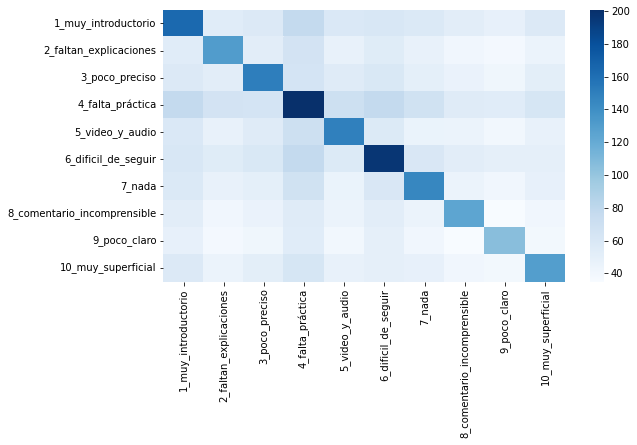

In [127]:
import itertools
import numpy as np

class MultiLabelCounter():
    def __init__(self, classes=None):
        self.classes_ = classes

    def fit(self,y):
        self.classes_ = sorted(set(itertools.chain.from_iterable(y)))
        self.mapping = dict(zip(self.classes_,
                                         range(len(self.classes_))))
        return self

    def transform(self,y):
        yt = []
        for labels in y:
            data = [0]*len(self.classes_)
            for label in labels:
                data[self.mapping[label]] +=1
            yt.append(data)
        return yt

    def fit_transform(self,y):
        return self.fit(y).transform(y)

    
mlc = MultiLabelCounter()
df = pd.DataFrame(mlc.fit_transform(df_agg_by_course["labels_list"]),
                          columns=mlc.classes_,
                          index=df_agg_by_course.index)

###################
df = df[df.sum(axis=1)>1]
display(df.sort_values("1_muy_introductorio",ascending=False).head())

###################
from sklearn.preprocessing import Normalizer
normalizeddf_train = Normalizer().fit_transform(df)
normalizeddf_train = pd.DataFrame(normalizeddf_train, columns = df.columns, index = df.index)
normalizeddf_train

fruits_corr = normalizeddf_train.corr(method = "pearson")
fruits_freq_mat = np.dot(normalizeddf_train.T, normalizeddf_train)
fruits_freq = pd.DataFrame(fruits_freq_mat, columns = label_dicc.values(), index = label_dicc.values())
display(fruits_freq)

###################
import seaborn as sn
fig, ax = plt.subplots(figsize = (9,5))
sn.heatmap(fruits_freq, cmap = "Blues")
plt.xticks(rotation=90)
plt.savefig("heatmap.png", dpi = 300)
